In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from galaxy2galaxy import problems
import galflow as gf
import tensorflow as tf

tf.enable_eager_execution()

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

tf.version.VERSION

'1.15.0'

In [2]:
import sys
path = '/local/home/ua264756/GitHub/ADMM/'
sys.path.insert(1, path)

import plot_utils
from helper_func import *

In [3]:
tf.executing_eagerly()

True

### Pre-processing Function

In [4]:
norm_fact = 100

def pre_proc_unet(dico):
    r"""Preprocess the data and adds noise to generate the input galaxy images.

    This function takes the dictionnary of galaxy images and PSFs for the input and
    the target and returns a list containing 3 arrays: an array of noisy galaxy images, 
    an array of target galaxy images, and an array of PSFs

    Parameters
    ----------
    dico : dictionnary
        Array_like means all those objects -- lists, nested lists, etc. --
        that can be converted to an array.  We can also refer to
        variables like `var1`.

    Returns
    -------
    list
        list containing 3 arrays: an array of noisy galaxy images, 
        an array of target galaxy images, and an array of PSFs
    
    Example
    -------
    These are written in doctest format, and should illustrate how to
    use the function.

    >>> from galaxy2galaxy import problems # to list avaible problems run problems.available()
    >>> problem128 = problems.problem('attrs2img_cosmos_hst2euclide')
    >>> dset = problem128.dataset(Modes.TRAIN, data_dir='attrs2img_cosmos_hst2euclide')
    >>> dset = dset.map(pre_proc_unet)
    """
        
    # Normalize tagets 
    dico['targets'] *= norm_fact 
    
    # Interpolation
    x_interpolant = tf.image.ResizeMethod.BICUBIC
    interp_factor = 2
    Nx, Ny = np.shape(dico['targets'])[0], np.shape(dico['targets'])[1]
    
    dico['targets'] = tf.image.resize(dico['targets'], [Nx*interp_factor, Ny*interp_factor],
                                      method = x_interpolant)

    # SNR & noise std 
    SNR = [1.5, 2.0, 3.0, 4.0, 5.0]
    sigma_noise = tf.math.reduce_max(dico['targets']) / SNR  
    
    noisemap = tf.random_normal(shape=(np.shape(dico['targets'])[0], np.shape(dico['targets'])[1], len(SNR)),
                                mean=0.0, 
                                stddev=sigma_noise, 
                                dtype=tf.float32)
    
    # Add noise to inputs
    dico['inputs']  = tf.transpose(dico['targets'] + noisemap)
    
    # FFT of noisy inputs
    fft_gal = []
    for i in range(len(SNR)):
        fft_gal.append(tf.signal.fftshift(tf.signal.fft2d(tf.cast(dico['inputs'][i,...], tf.complex64))))

    # Extract Mask
    dico['mask'] = tf.expand_dims(tf.identity(dico['psf']), axis=0)
    #dico['mask'] /= tf.math.reduce_max(dico['mask'])
    
    # Resize PSF to 128 X 128 using area interpolation
    dico['psf'] = tf.signal.ifftshift(tf.signal.irfft2d(tf.cast(tf.squeeze(dico['psf']), tf.complex64)))
    dico['psf'] = tf.image.resize(tf.expand_dims(dico['psf'], axis=-1), [Nx, Ny],
                                  method = x_interpolant) 
    dico['psf'] = tf.expand_dims(dico['psf'], axis=0) / tf.math.reduce_max(dico['psf'])

    # Convolve with PSF
    inputs = []
    for j in range(len(SNR)): 
        temp = dico['inputs'][j,...]
        temp = tf.expand_dims(tf.signal.rfft2d(temp), axis=0)
        inputs.append(gf.kconvolve(temp, 
                                   tf.squeeze(tf.cast(dico['mask'], tf.complex64), axis=-1),  
                                   zero_padding_factor = 1, 
                                   interp_factor = interp_factor))
    
    dico['targets'] = tf.image.resize(dico['targets'], [Nx, Ny],
                                      method = x_interpolant)
 
    return tf.squeeze(inputs), dico['targets'], tf.squeeze(dico['psf']), sigma_noise, tf.math.abs(fft_gal)

### Loading Galaxy Images & PSF

In [5]:
with tf.compat.v1.Session() as sess:
    
    # Let's create an instance of the meerkat_3600 problem
    Modes = tf.estimator.ModeKeys
    problem128 = problems.problem('meerkat_3600')
    dset = problem128.dataset(Modes.EVAL, data_dir='/local/home/ua264756/Data/meerkat_3600')
    dset = dset.repeat()
    dset = dset.map(pre_proc_unet)
    n_batch = 1601
    dset = dset.batch(n_batch)

    # Build an iterator over the dataset
    iterator = dset.make_one_shot_iterator().get_next()

    # Initialize batch
    batch = sess.run(iterator)


INFO:tensorflow:Reading data files from /local/home/ua264756/Data/meerkat_3600/meerkat_3600-dev*
INFO:tensorflow:partition: 0 num_data_files: 2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


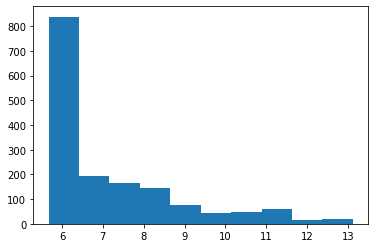

In [6]:
norm_psf = np.array([np.linalg.norm(psf) for psf in batch[2]])
plt.hist(norm_psf)
plt.show()

In [7]:
batch[0].shape

(1601, 5, 128, 128)

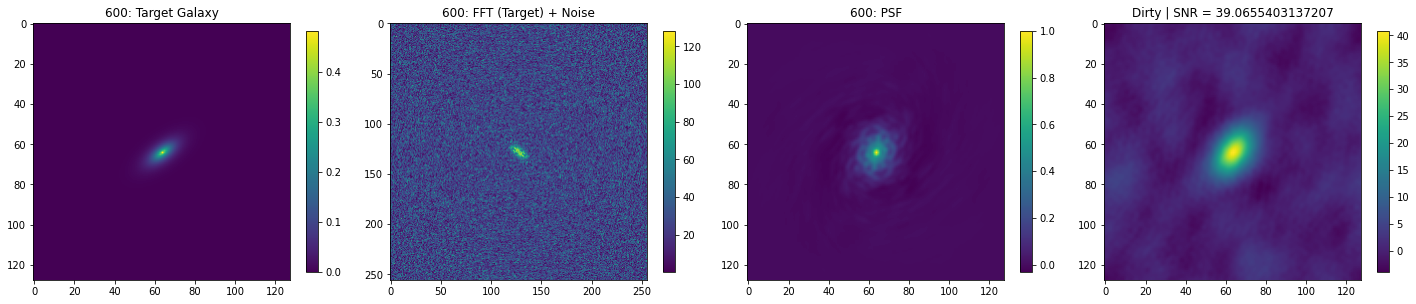

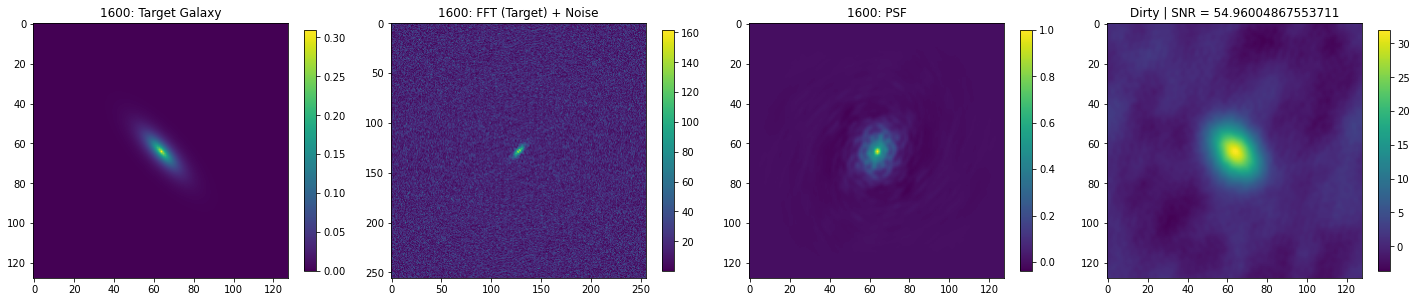

In [8]:
# Plot all galaxies for 1 SNR value
for i in [600, 1600]:
    SNR_ind = 3
    dirty = batch[0][i,SNR_ind,...]
    SNR = np.max(dirty)/np.std(dirty[0:20,0:20])
    plt.figure(figsize=(20,20))
    plt.subplot(141)
    plt.imshow(np.squeeze(batch[1][i])); plt.colorbar(shrink=0.17); plt.title('{}: Target Galaxy'.format(i))
    plt.subplot(142)
    plt.imshow(np.squeeze(batch[4][i,SNR_ind,...])); plt.colorbar(shrink=0.17); plt.title('{}: FFT (Target) + Noise'.format(i))
    plt.subplot(143)
    plt.imshow(np.squeeze(batch[2][i])); plt.colorbar(shrink=0.17); plt.title('{}: PSF'.format(i))
    plt.subplot(144)
    plt.imshow(np.squeeze(dirty)); plt.colorbar(shrink=0.17); plt.title('Dirty | SNR = {}'.format(SNR))
    plt.tight_layout()
    plt.show()

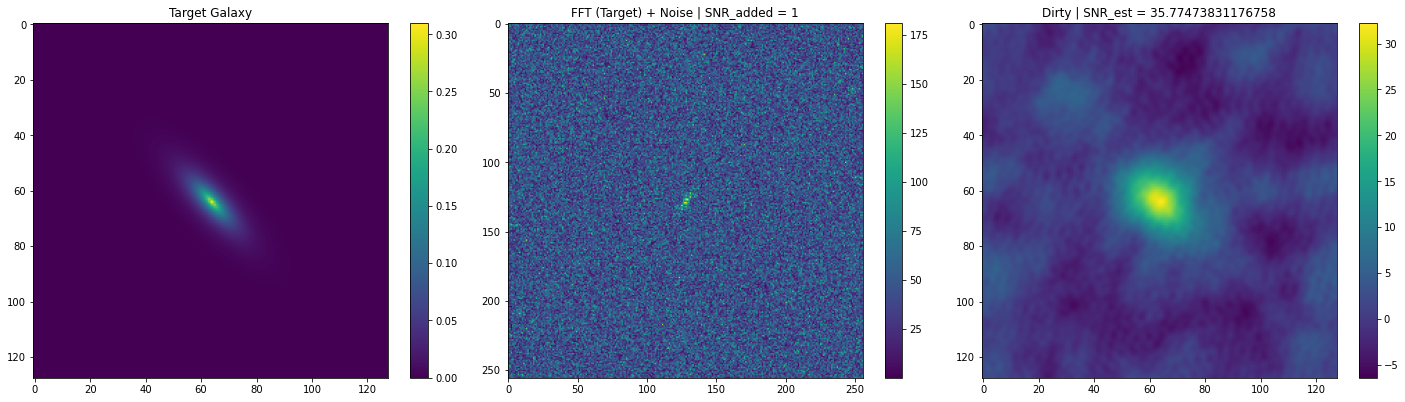

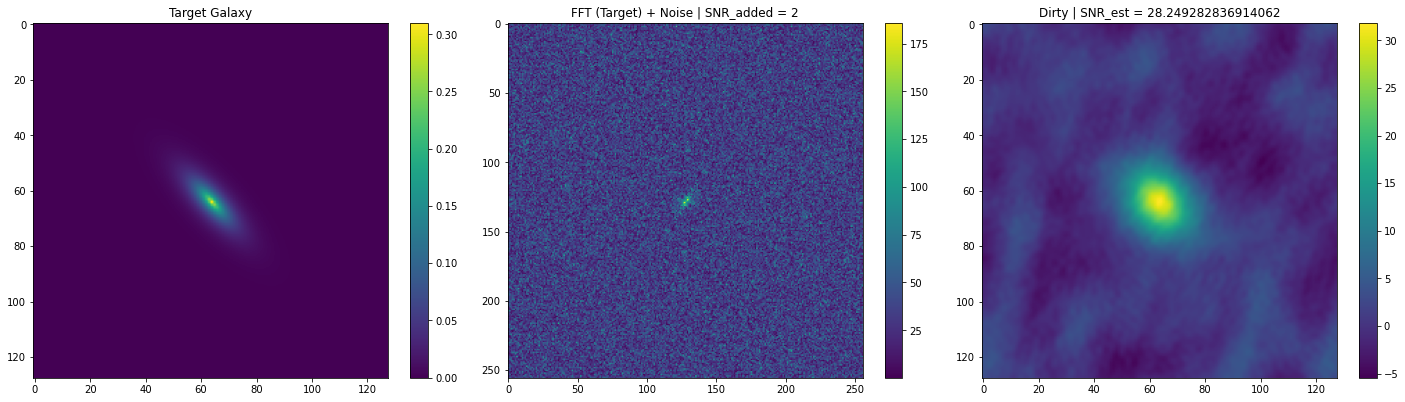

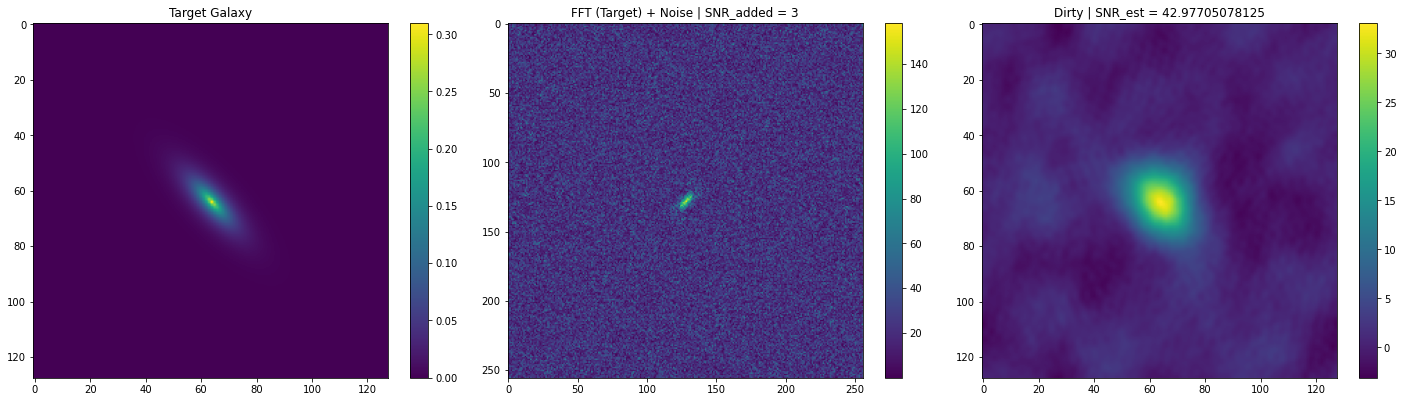

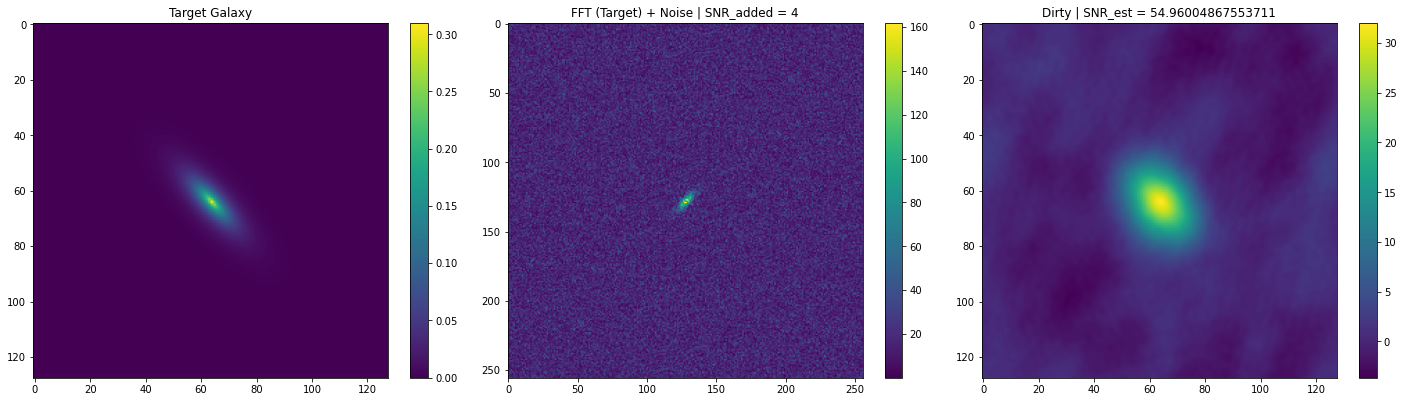

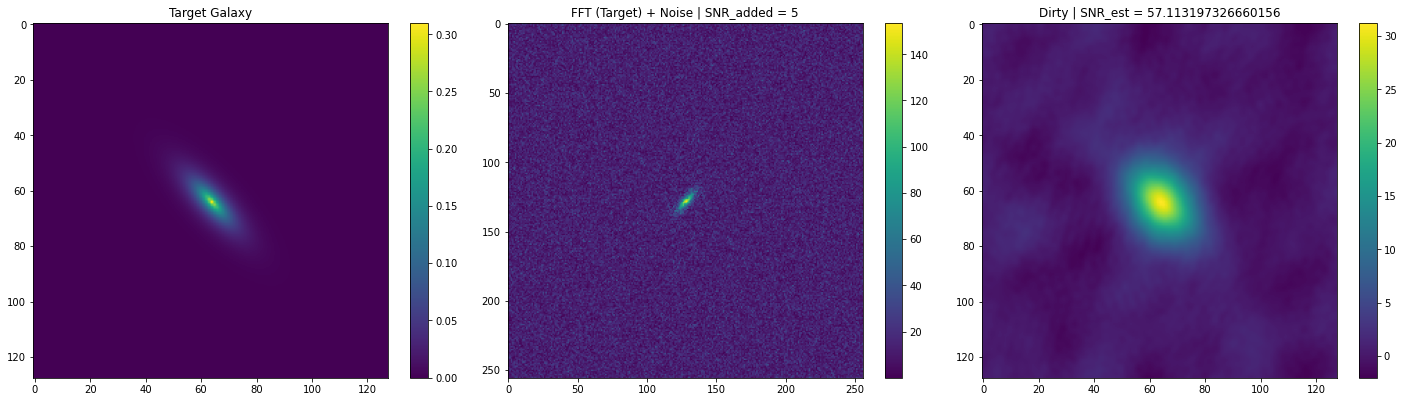

In [9]:
# Plot 1 galaxy for all SNR values
for j in range(batch[3].shape[1]):
    gal_ind = 1600
    dirty = batch[0][gal_ind,j,...]
    SNR = np.max(dirty)/np.std(dirty[0:20,0:20])
    plt.figure(figsize=(20,20))
    plt.subplot(131)
    plt.imshow(np.squeeze(batch[1][gal_ind])); plt.colorbar(shrink=0.25); plt.title('Target Galaxy')
    plt.subplot(132)
    plt.imshow(np.squeeze(batch[4][gal_ind,j,...])); plt.colorbar(shrink=0.25); plt.title('FFT (Target) + Noise | SNR_added = {}'.format(j+1))
    plt.subplot(133)
    plt.imshow(np.squeeze(dirty)); plt.colorbar(shrink=0.25); plt.title('Dirty | SNR_est = {}'.format(SNR))
    plt.tight_layout()
    plt.show()

### Load Trained U-Net Model

In [10]:
model_1 = tf.keras.models.load_model(path + 'UNet_Denoiser/Models/UNet_radio_F{3600}_ep{20}spe{6250}nb{32}_WGN_fact{100}_SNR{1-50}', compile=False)

# Forward-Backward Algorithm

#### The loss function

$ L(x) = \frac{1}{2\sigma^2} \lVert Hx - y \rVert_2^2 \\\\\\ 
\nabla L(x) = \frac{1}{\sigma^2} H^T(Hx - y)  \\\\\\
\nabla L(x_{true}) = \frac{1}{\sigma^2} H^Tn; \hspace{0.75cm} since \hspace{0.5cm} y = Hx_{true} + n\hspace{0.75cm} s.t. \hspace{0.5cm} n \hspace{0.25cm} WAGN \\\\\\ $

#### Compute Variance of -

$ \hspace{0.75cm} \alpha\nabla L(x_{true}) = \frac{\alpha}{\sigma^2} H^Tn \\\\\\ 
\hspace{0.75cm} \text {Cov[} \alpha \nabla L(x_{true})] = \frac{\alpha^2}{\sigma^4} \text {Cov[}(H^Tn)] = \frac{\alpha^2}{\sigma^4} \sigma^2 H^T H;  \hspace{0.75cm} \text{as  Cov(} H^Tn) = H^T \text{Cov(} n) (H^T)^T \\\\\\
\Rightarrow \hspace{0.25cm} {Cov[} \alpha \nabla L(x_{true})] = \frac{\alpha^2}{\sigma^2} H^TH \\\\\\ $

#### Now, 

$\hspace{0.8cm} AA^T [i,i] = \sum_j A[i,j]A^T[j,i] = \sum_j A^2[i,j] = \lVert A \rVert_F^2 \\\\\\ 
\therefore \hspace{0.25cm} \text {Cov(} \alpha \nabla L(x_{true}))[i,i] = \frac{\alpha^2}{\sigma^2} \lVert H \rVert_F^2 \\\\\\ 
\Rightarrow \hspace{0.25cm} \sigma_{grad} = \alpha \lVert H \rVert_F \sigma_{U-Net}\\\\\\ $


#### After plugging U-Net

$ L(x) = L_d + p(x), \hspace{0.75cm} where \hspace{0.5cm} L_d(x) = \frac{1}{2\sigma^2} \lVert Hx - y \rVert_2^2\\\\\\ $

##### Forward backward Splitting
While not converged:
$ \hspace{0.5cm} X^{(k+\frac{1}{2})} \leftarrow X^{(k)} - \alpha \nabla L_d(X^{(k)}) $
$\\\\\\ \hspace{4.1cm} X^{(k+1)} \leftarrow prox_\alpha X^{(k+\frac{1}{2})} \\\\\\ $

Note that: 
$ \hspace{0.5cm} Var (\frac{\sigma_0}{\sigma}n) = \frac{\sigma_0^2}{\sigma^2} Var(n) = \sigma_0^2$

##### Empirically estimate standard deviation of $\alpha \nabla L_d(x_{true})$ : $\hspace{0.5cm} \alpha H^T  n$
$ \hspace{0.5cm}x^{(0)} = 0 $
$ \\\\\\ \hspace{0.5cm}x^{(\frac{1}{2})} = x^{(0)} - \alpha \nabla L_d(x_{true}) $
$ \hspace{0.5cm}x^{(\frac{1}{2})} = \alpha H^T n $
$ \\\\\\ \hspace{0.5cm}Hx_{true} - y = n $

##### Check if:

$ \\\\\\ \hspace{0.5cm}np.std(x^{(\frac{1}{2})}) = np.std(\alpha H^T n) \hspace{1.0cm} (Empirical \hspace{0.175cm} value) \\\\\\ \hspace{2.75cm} = \alpha \lVert H \rVert_F \sigma \hspace{2.05cm} (Theoretical \hspace{0.175cm} value) $


In [11]:
# Projection - Enforce non-negative values
def proj(xi):
    
    return tf.cast(tf.math.maximum(xi, 0.0), tf.float32)
 
    
# H operator
def H(data, psf):
    
    return fftconvolve(data, psf)


# H transpose operator
def Ht(data, psf):
    
    return fftconvolve(data, tf.reverse(tf.reverse(psf, axis=[0]), axis=[1]))      # rotate by 180


# The gradient
def grad(y, x_rec, psf):

    return Ht(H(x_rec, psf) - y, psf)


# The cost function
def cost_func(y, x_rec, psf, var):

    L_d = (tf.cast(0.5, tf.float32) / var) * tf.norm(y - H(x_rec, psf))**2      
    return tf.keras.backend.eval(L_d)


# Spectral value
def max_sv(psf):
    
    H = tf.signal.fft2d(tf.cast(psf, tf.complex64))
    normH = tf.math.abs(tf.reverse(tf.reverse(H, axis=[0]), axis=[1]) * H)
    return tf.cast(tf.math.reduce_max(normH), tf.float32)
     
    
# Compute gradient step size   
def get_alpha(sv):

    return (tf.cast(1.0, tf.float32) / 
            (sv * tf.cast(1.0 + 1.0e-5, tf.float32)))


def runFBS(y, x_0, psf, grad, sigma_noise, disp_step, n_iter, model):    

    # Convert arrays to tensors 
    x_0 = tf.cast(x_0, tf.float32)
    x_k = x_0
  
    # declare variables    
    cost = []
    nmse_arr = np.full(n_iter, np.inf)
    x_opt = tf.zeros(tf.shape(y.shape), tf.float32)
    
    sigma = tf.cast(sigma_noise, tf.float32)
    
    sv = max_sv(psf)
    alpha = get_alpha(sv)

    for k in range(n_iter):
        
        ## Gradient Descent update  
        x_k1 = x_k - alpha * grad(y, x_k, psf)   
        
        # U-Net Denoising
        x_k1 = tf.expand_dims(tf.expand_dims(x_k1, axis=0), axis=-1)
        x_k1 = tf.cast(tf.squeeze(model(x_k1)), tf.float32)
        
        ## Cost
        cost.append(cost_func(y, x_k1, psf, var=sigma**2))          
    
        # Update variables
        x_k = x_k1
                
        # Reconstruction
        final_im = x_k
                       
        # Compute NMSE
        nmse_arr[k] = nmse(gal_target_tf, final_im)       
        
        # Check if optimal reconstruction is achieved
#         if nmse_arr[k]==np.min(nmse_arr):
#         if ((nmse_arr[k] - nmse_arr[k-1])/nmse_arr[k] < 1.0e-10) and  k!=0:
#             x_opt = final_im
    
        x_opt = final_im
           
        # Display plots
        if (k+1)%disp_step==0:
            plot_utils.plot_iter(final_im, gal_target, y, k+1)
                 
    return x_opt, cost, nmse_arr

### Run FBS



 Gal_ind = 1600 | SNR_ind = 0




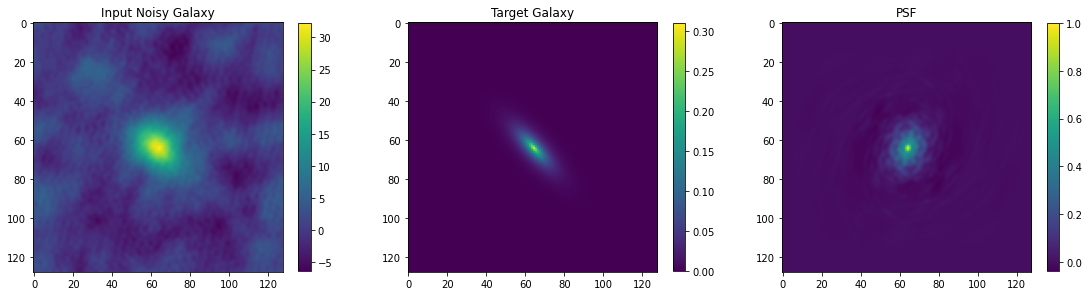

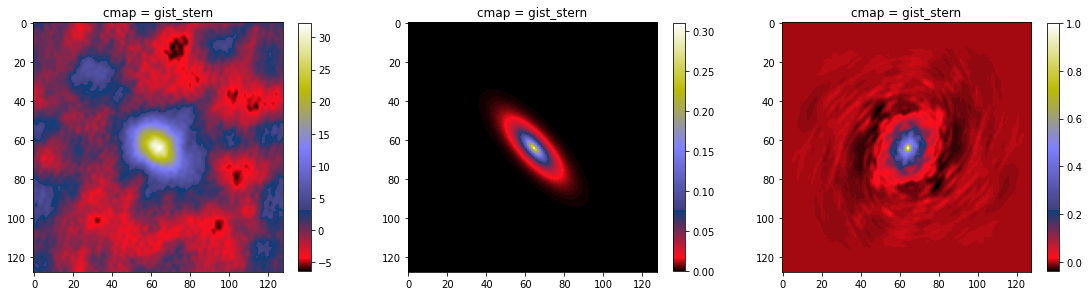

SNR (in Direct Space) = 35.77474
Noise Std (in Direct Space) = 0.9011781
PSF max. pixel value =  1.0


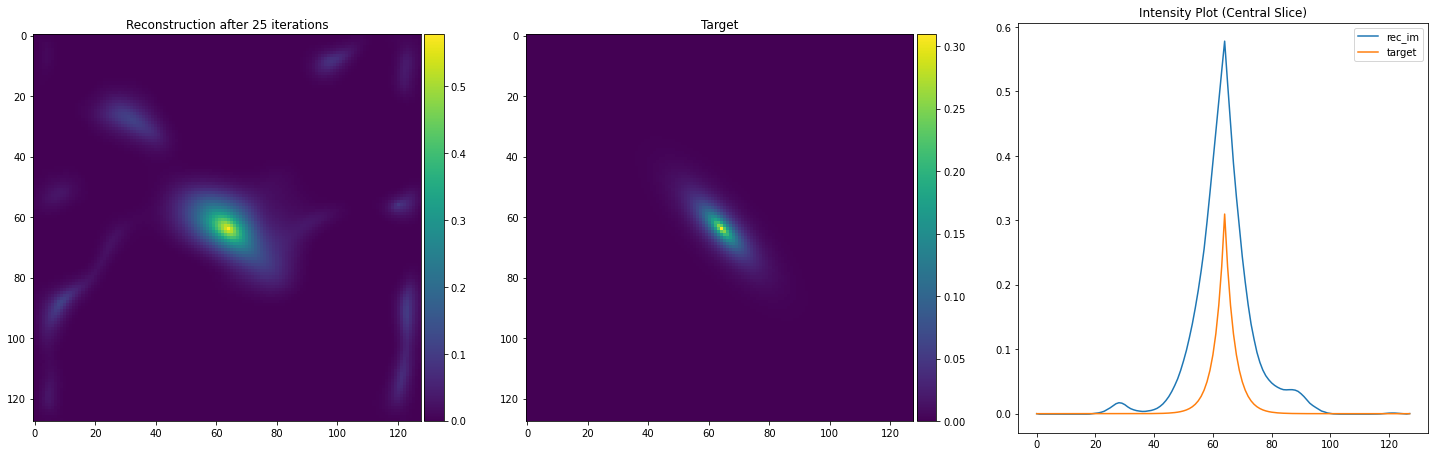

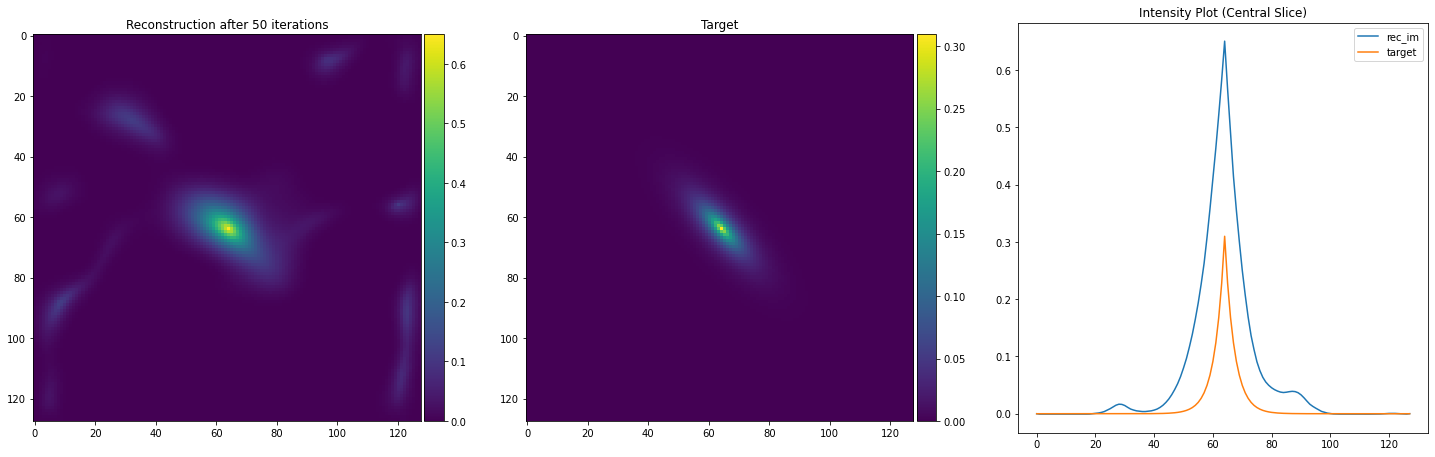

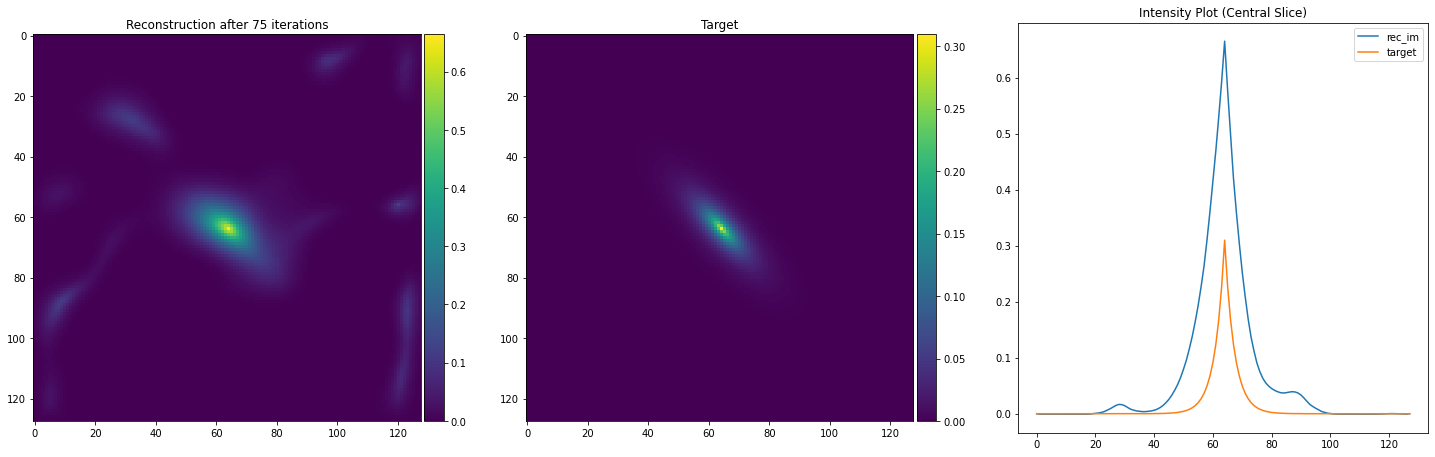

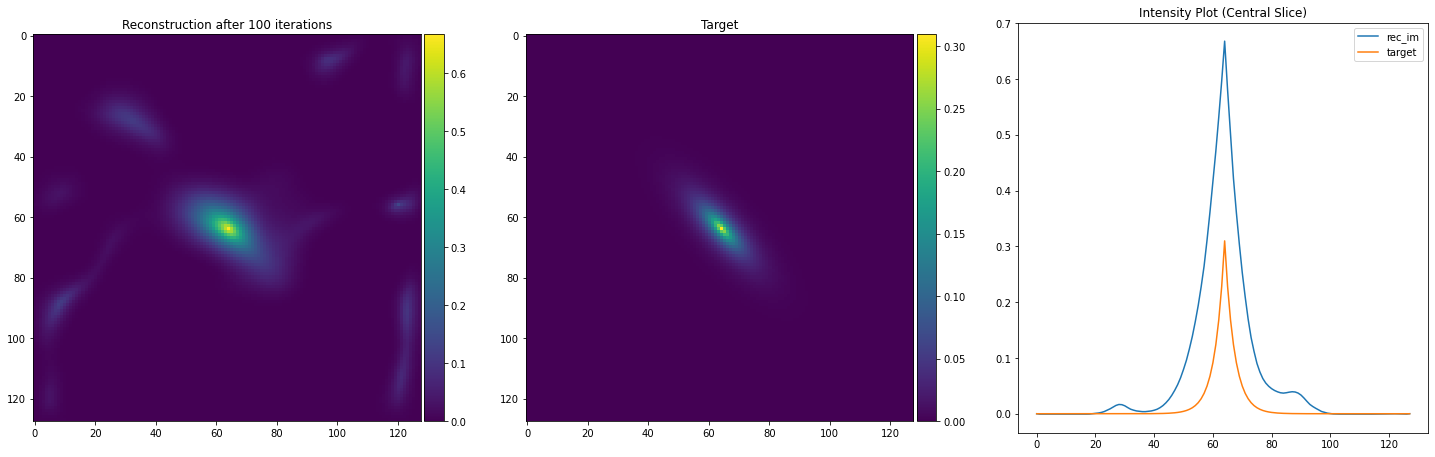

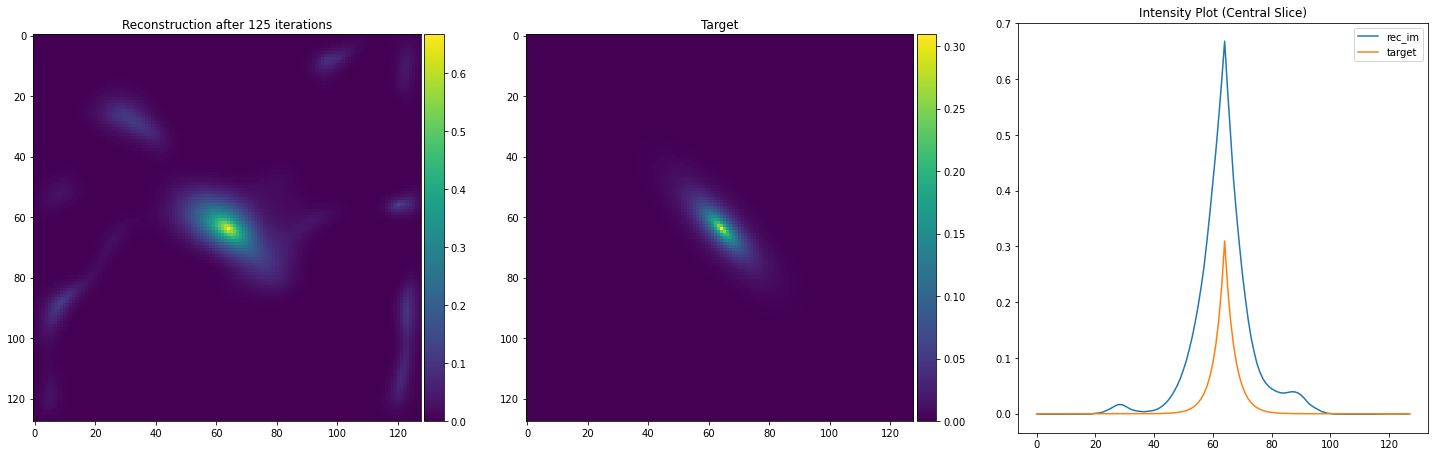

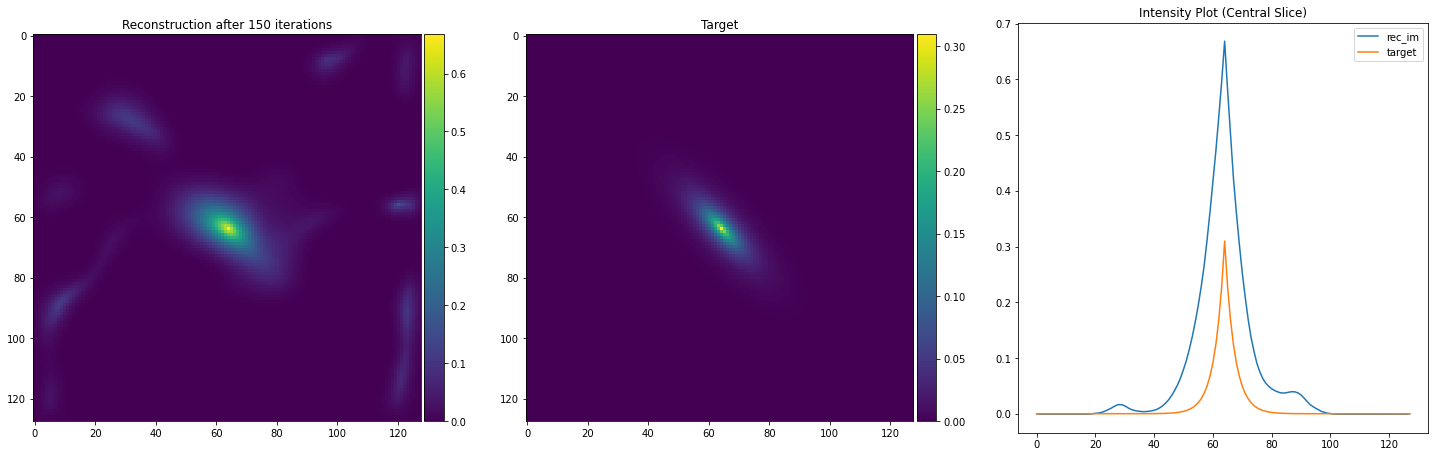

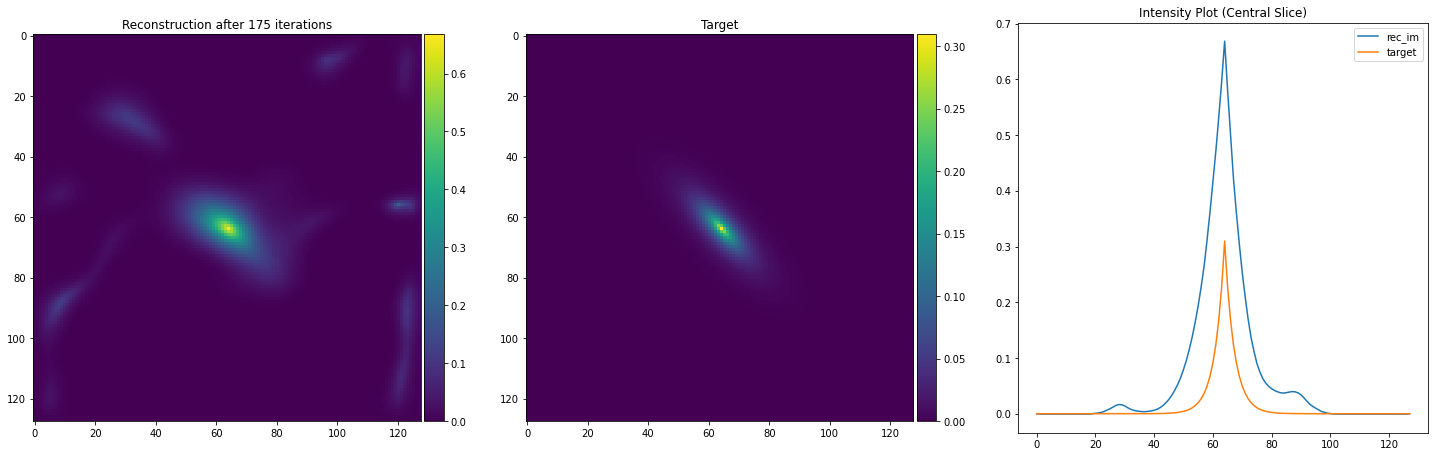

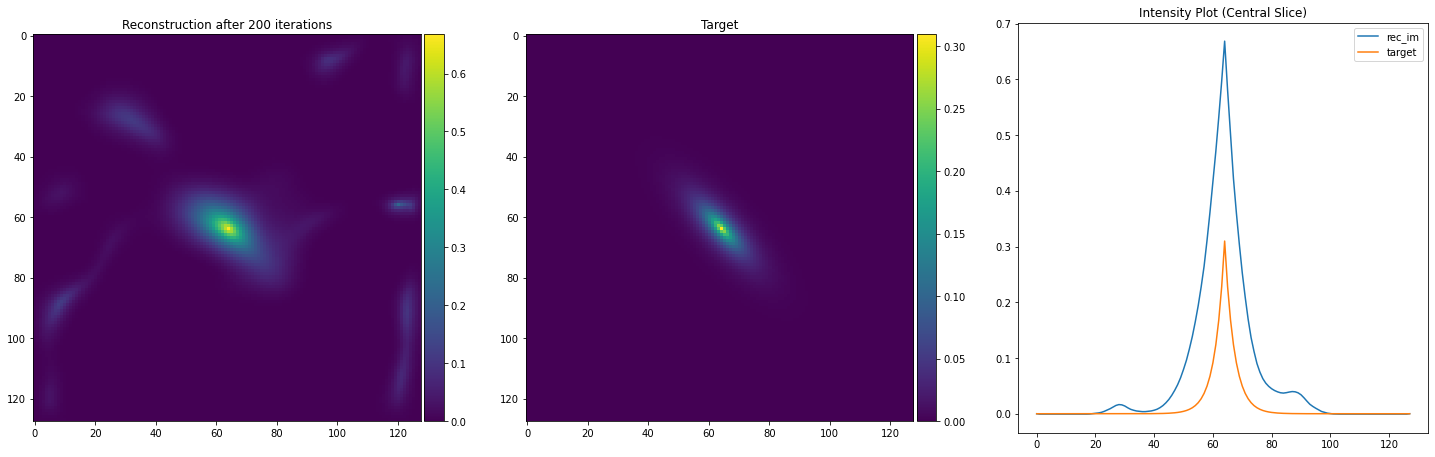

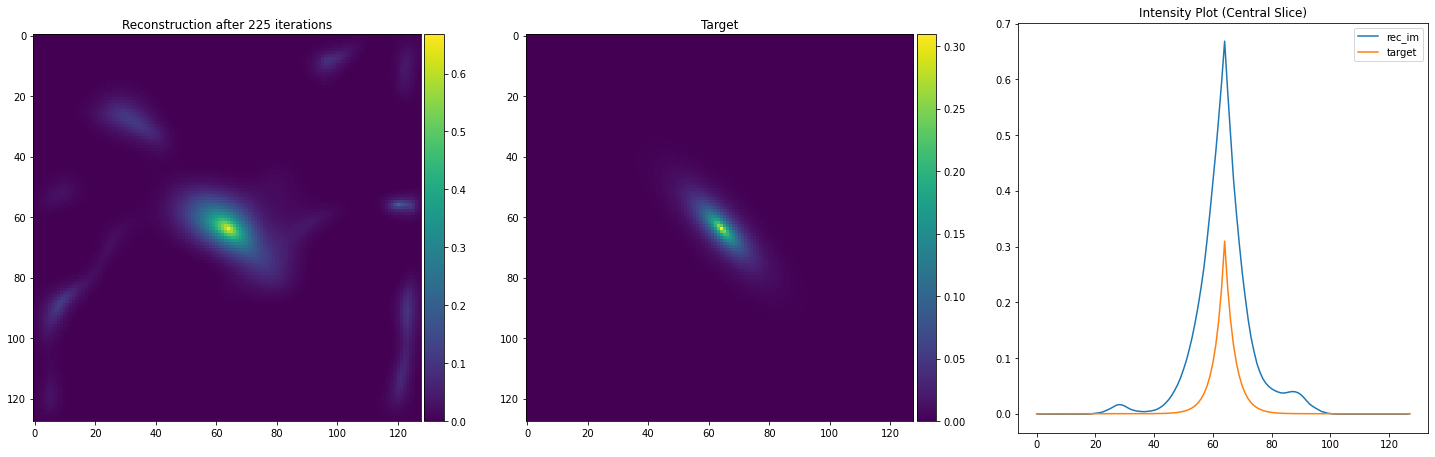

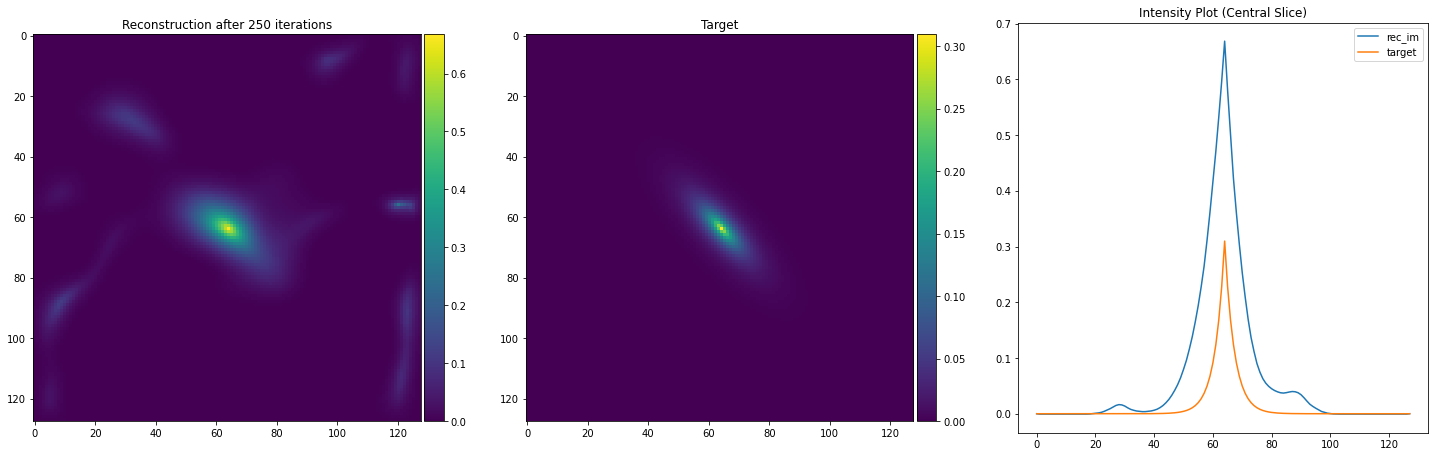

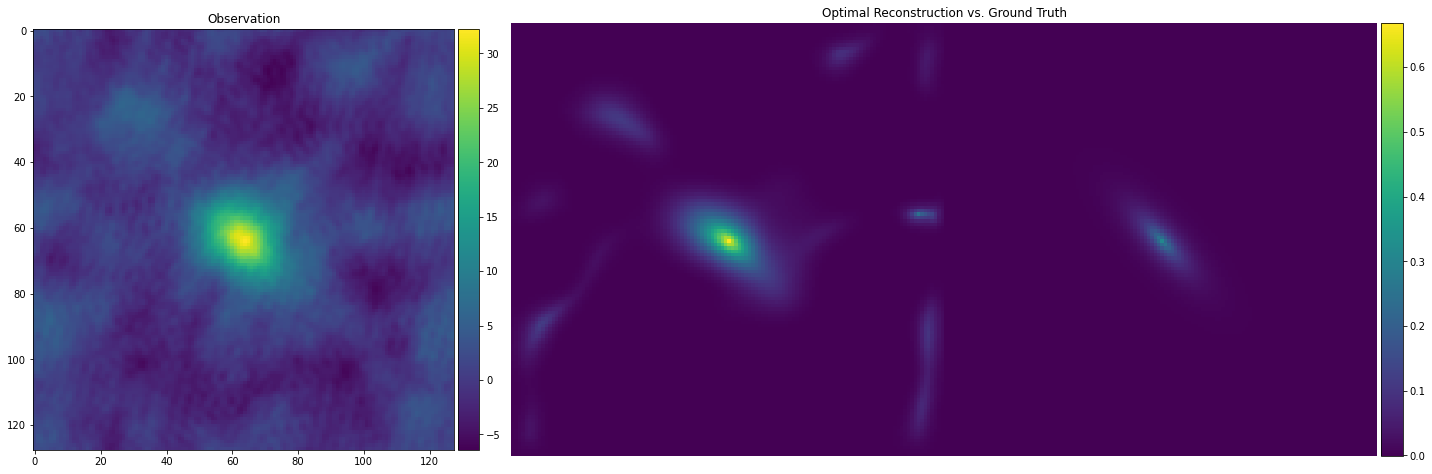

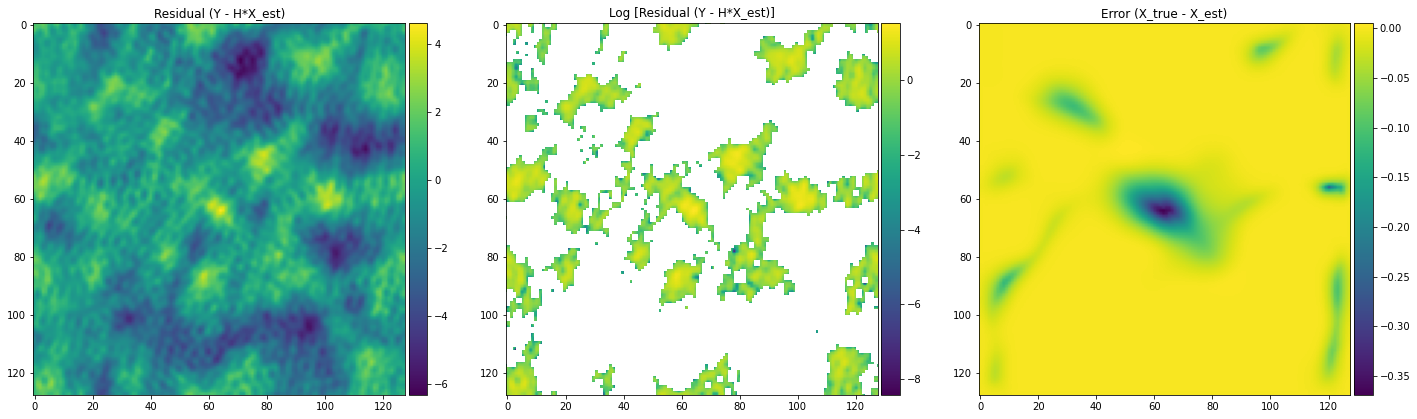

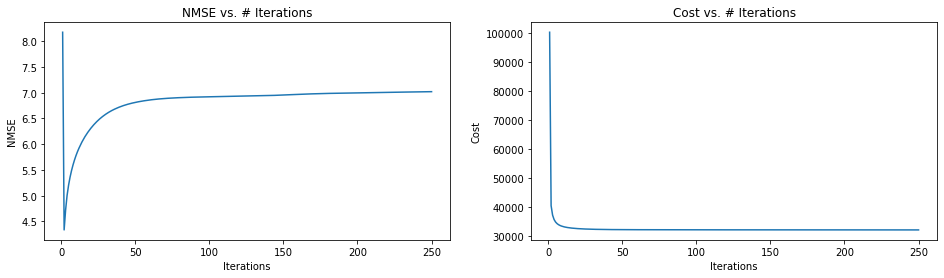


Minimum NMSE = 4.335500717163086 (at [2] iterations)
Minimum Cost = 32171.55078125 (at [250] iterations)


 Gal_ind = 1600 | SNR_ind = 1




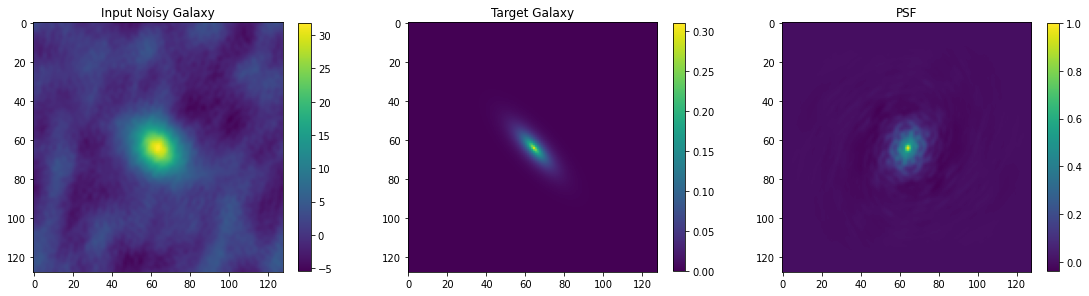

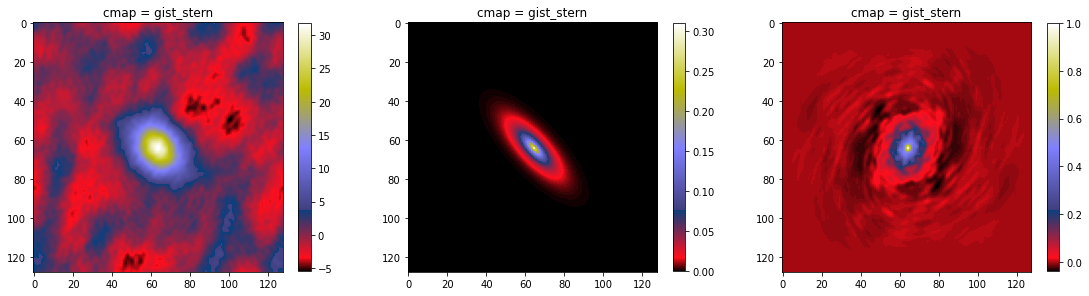

SNR (in Direct Space) = 28.249283
Noise Std (in Direct Space) = 1.1261234
PSF max. pixel value =  1.0


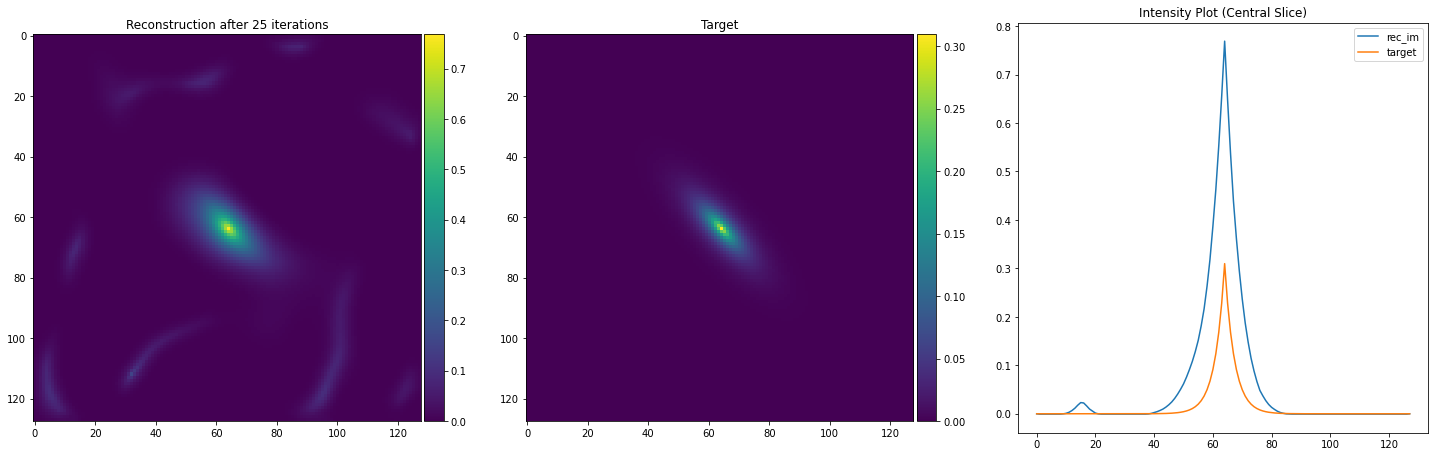

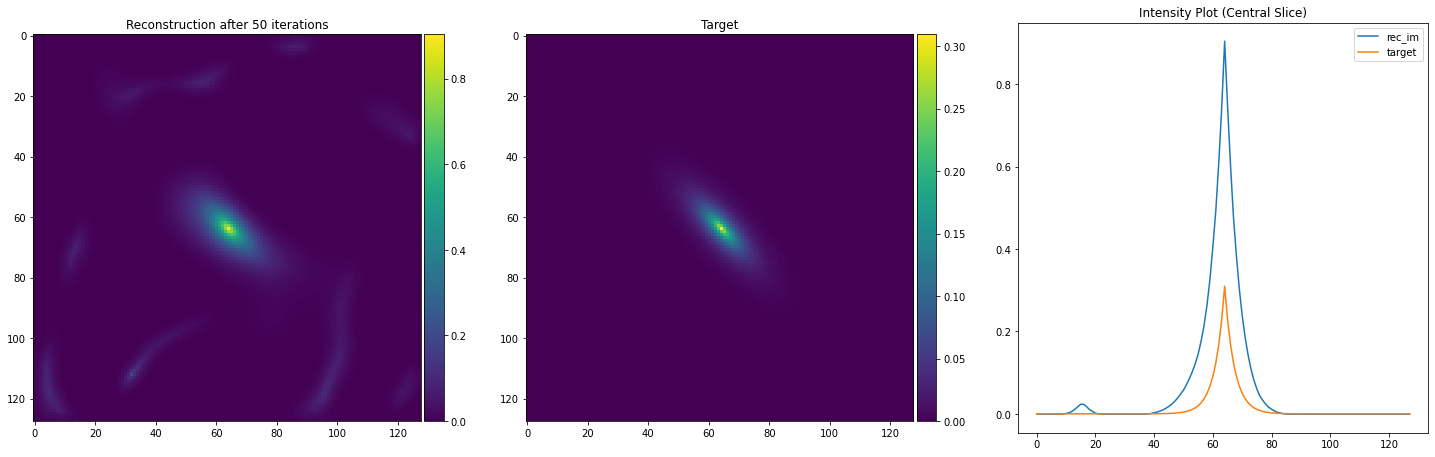

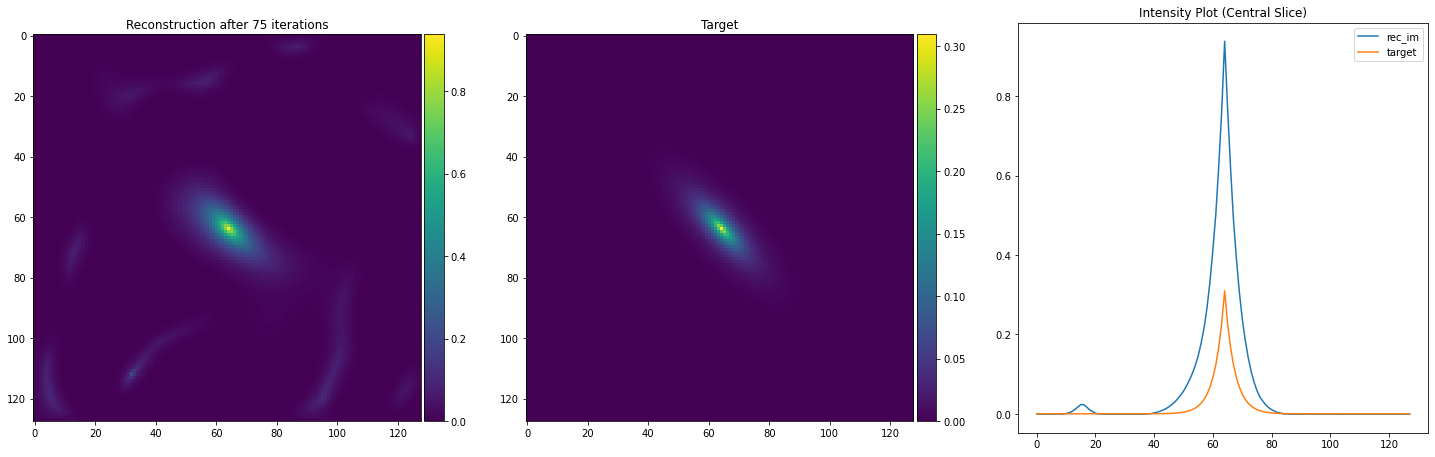

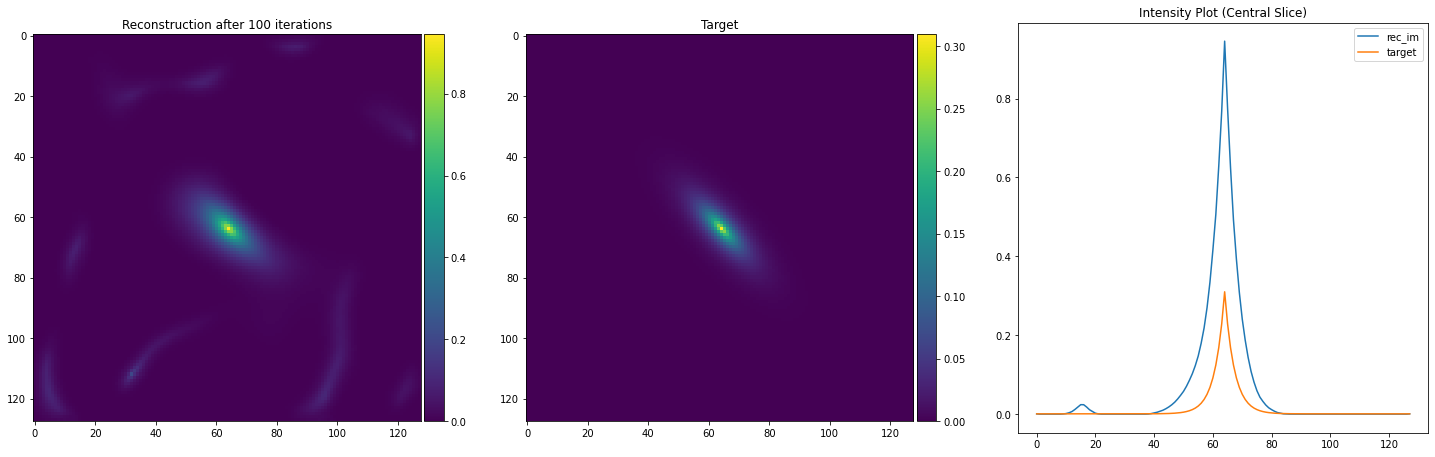

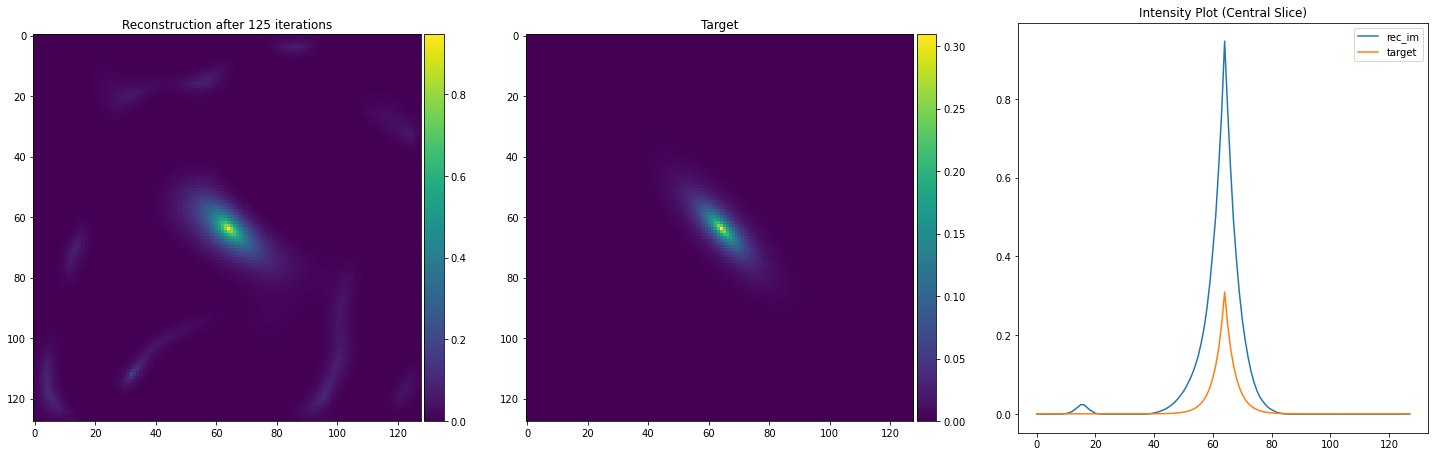

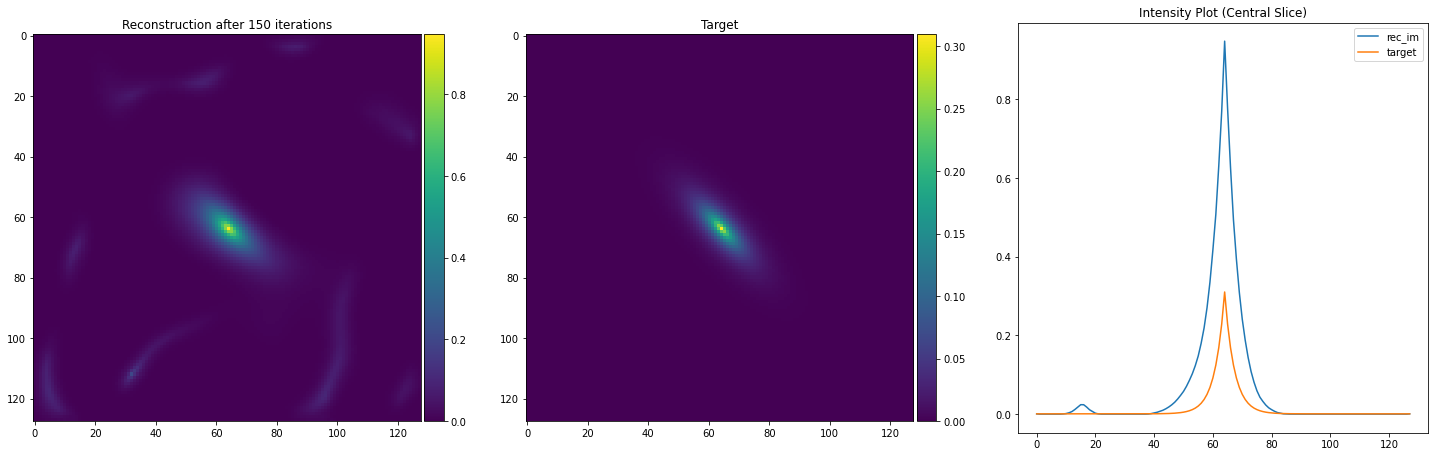

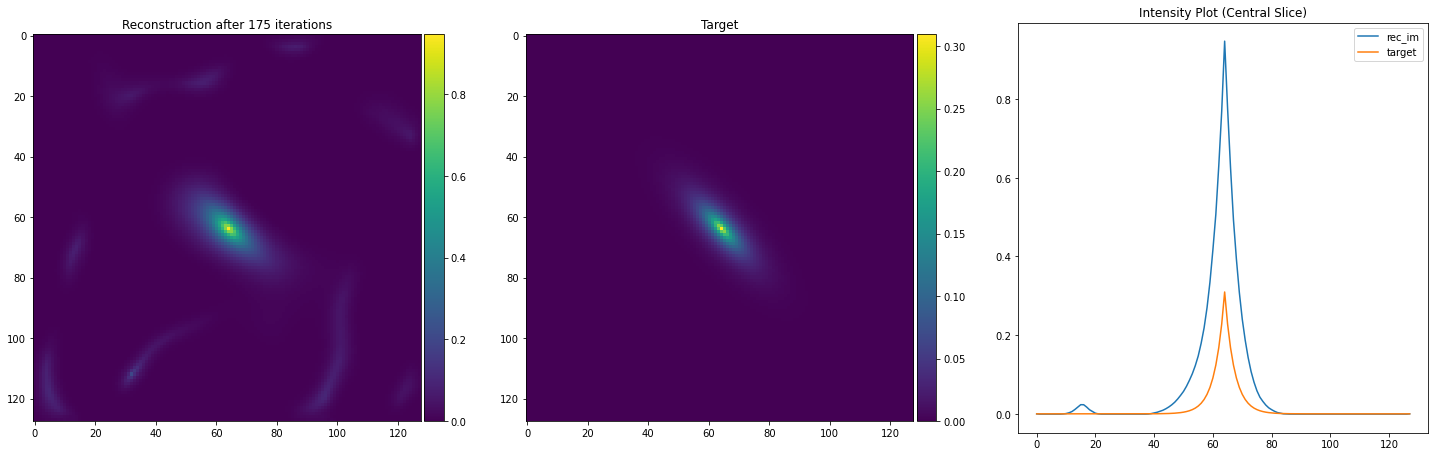

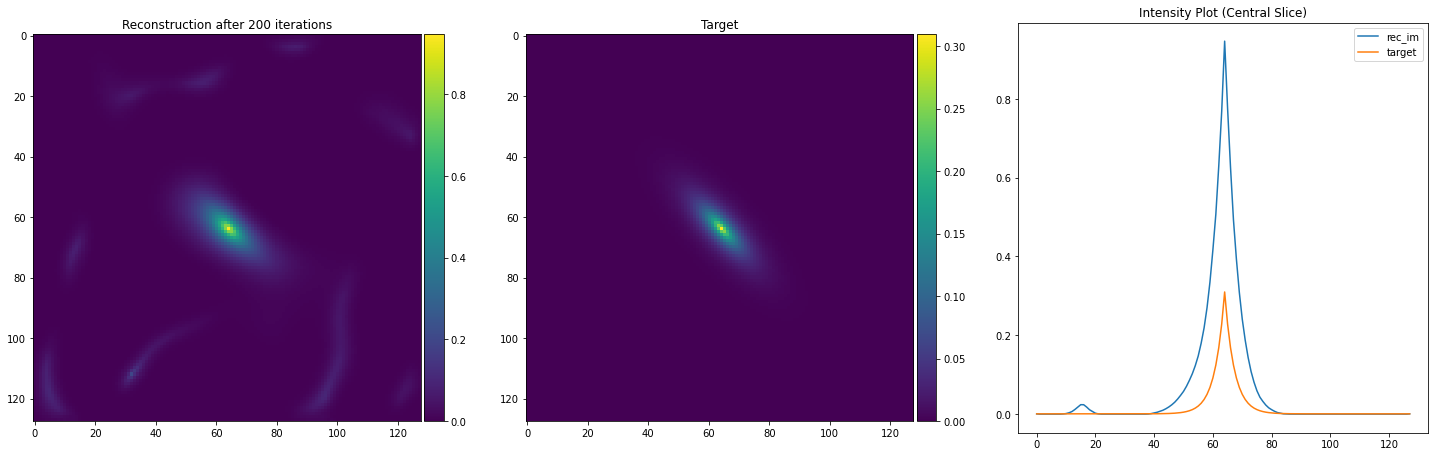

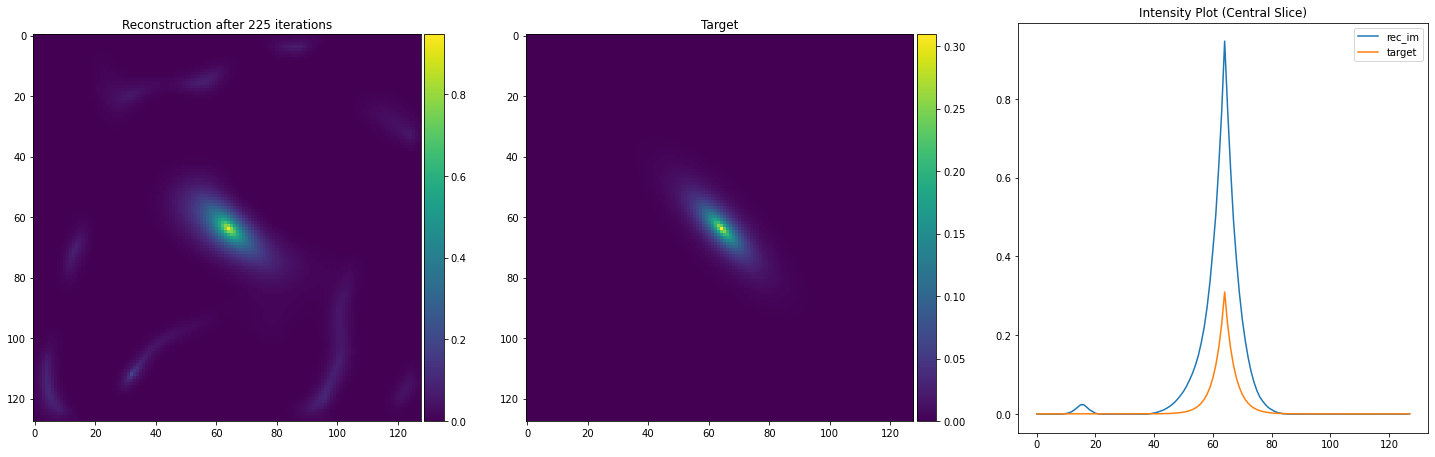

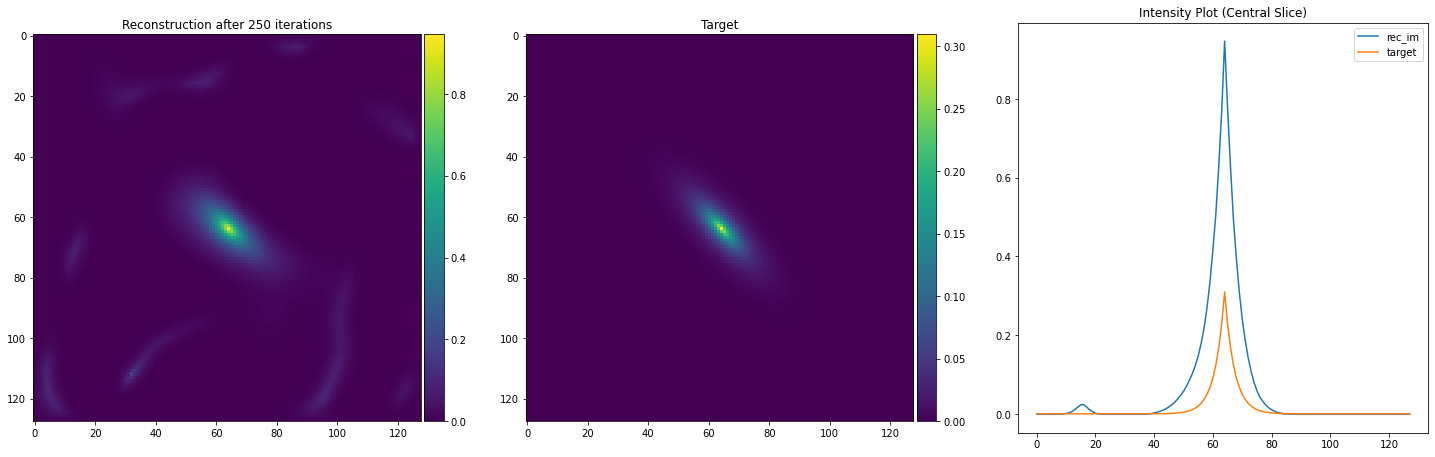

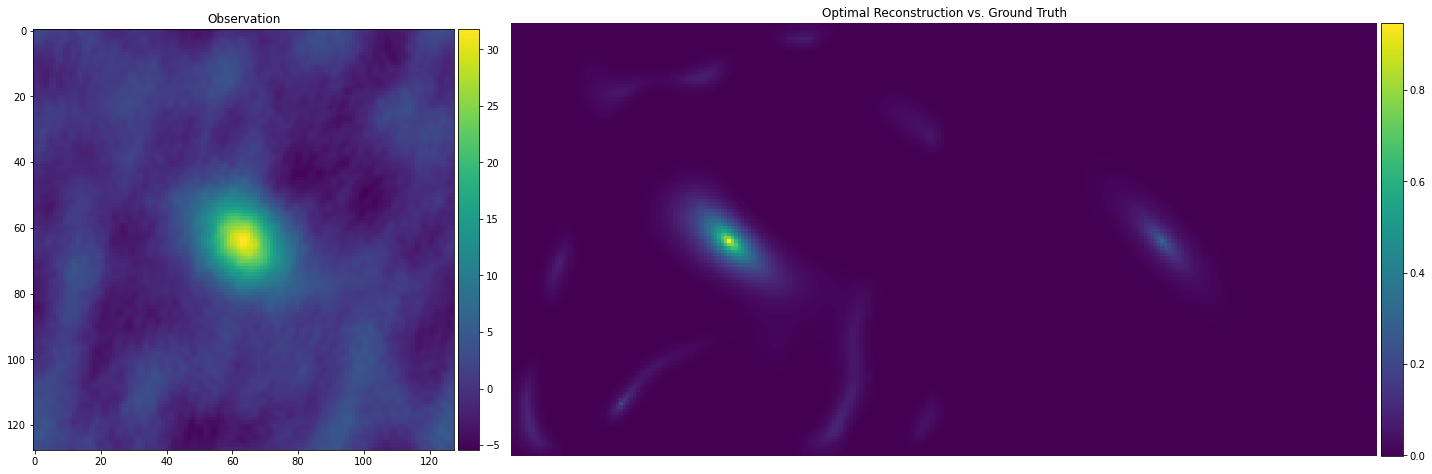

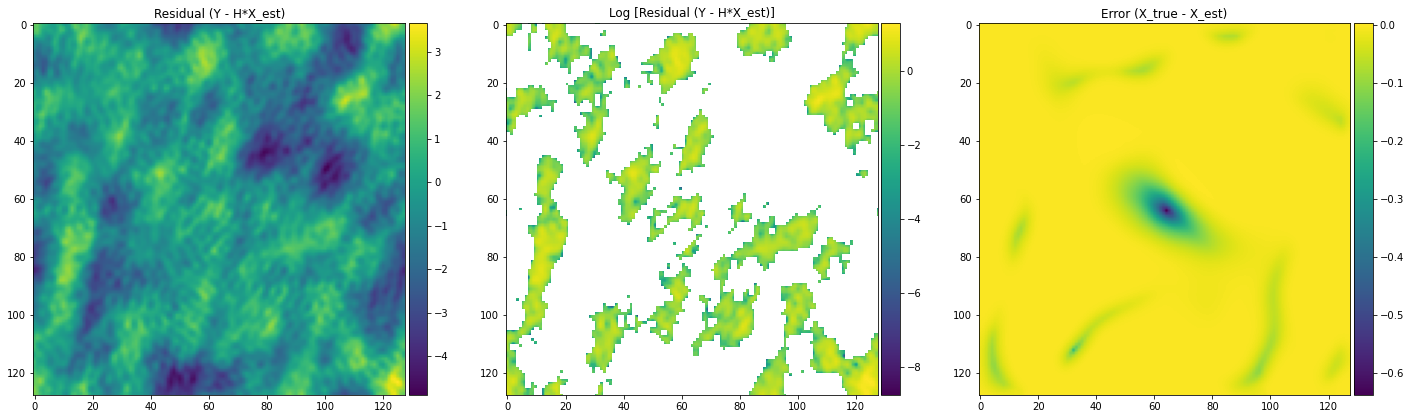

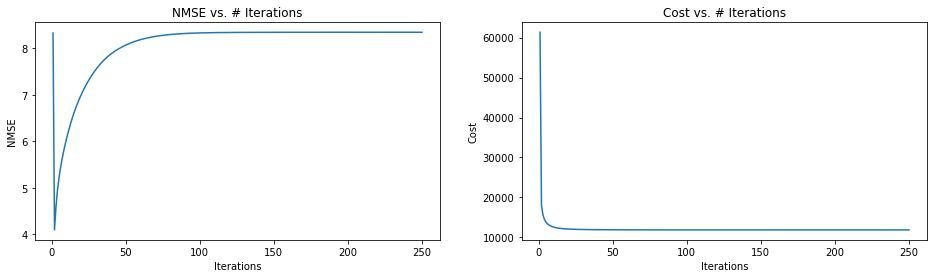


Minimum NMSE = 4.0936384201049805 (at [2] iterations)
Minimum Cost = 11845.0556640625 (at [250] iterations)


 Gal_ind = 1600 | SNR_ind = 2




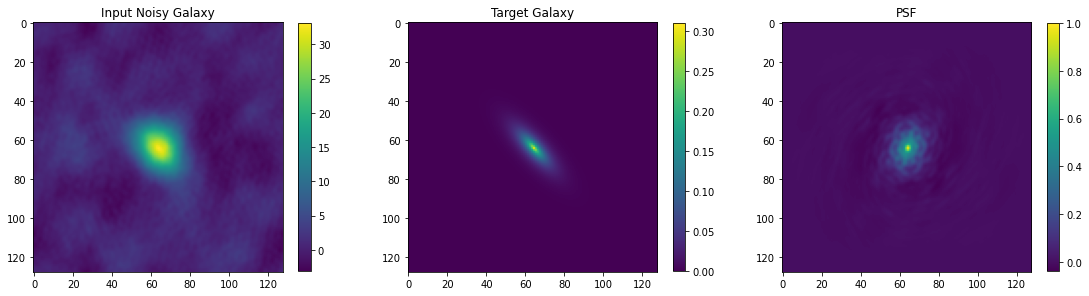

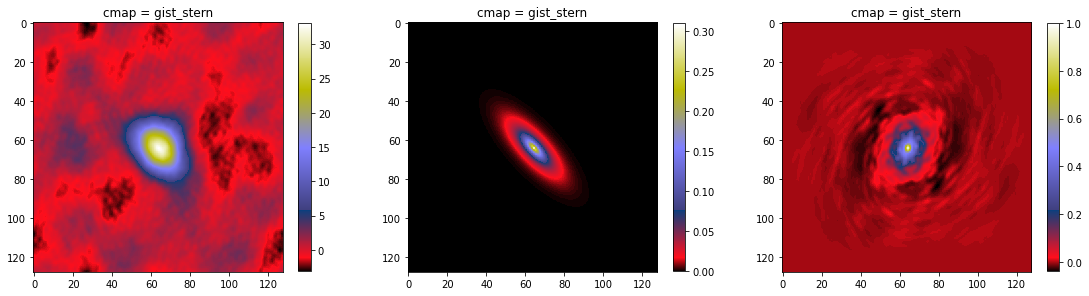

SNR (in Direct Space) = 42.97705
Noise Std (in Direct Space) = 0.7703034
PSF max. pixel value =  1.0


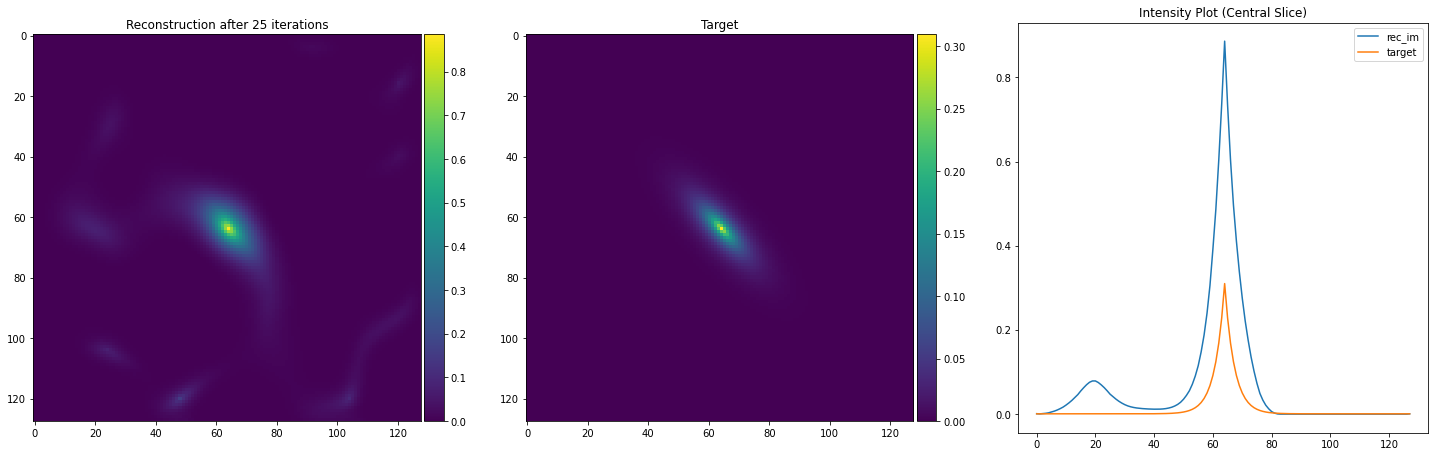

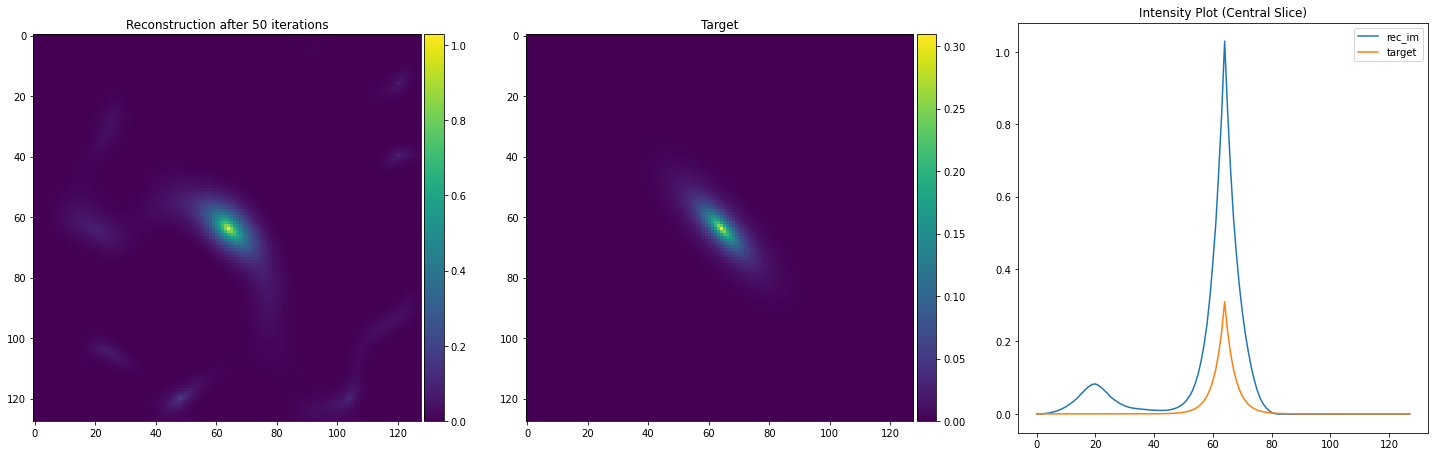

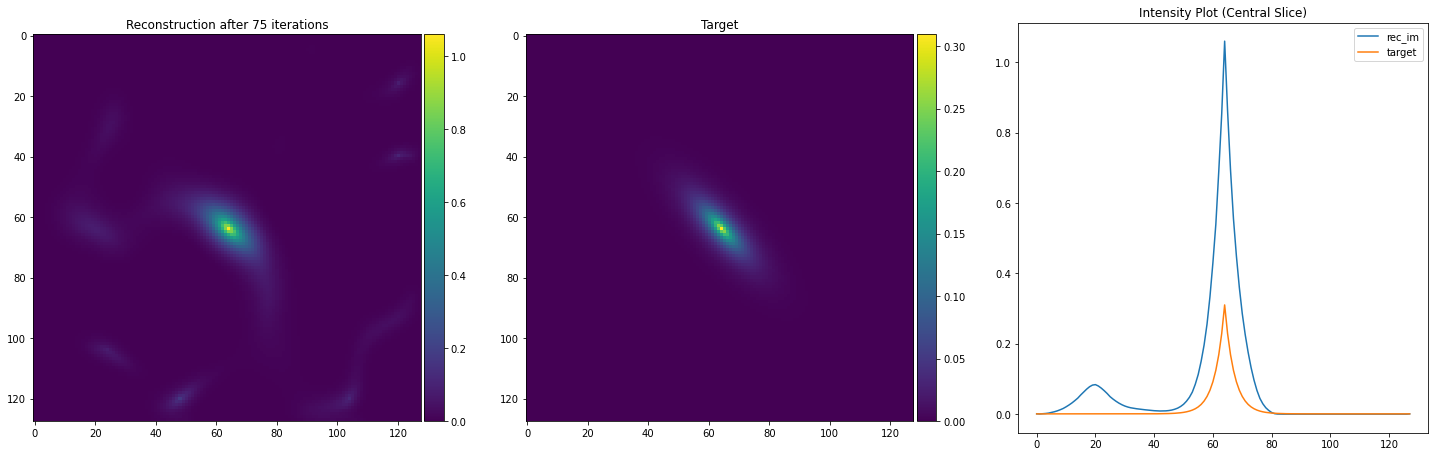

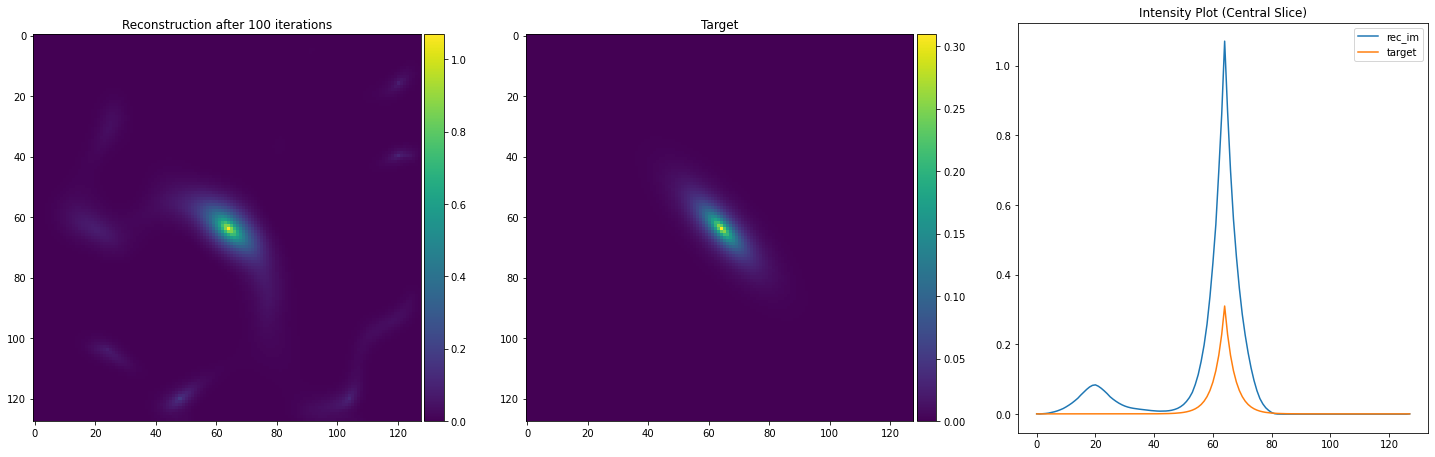

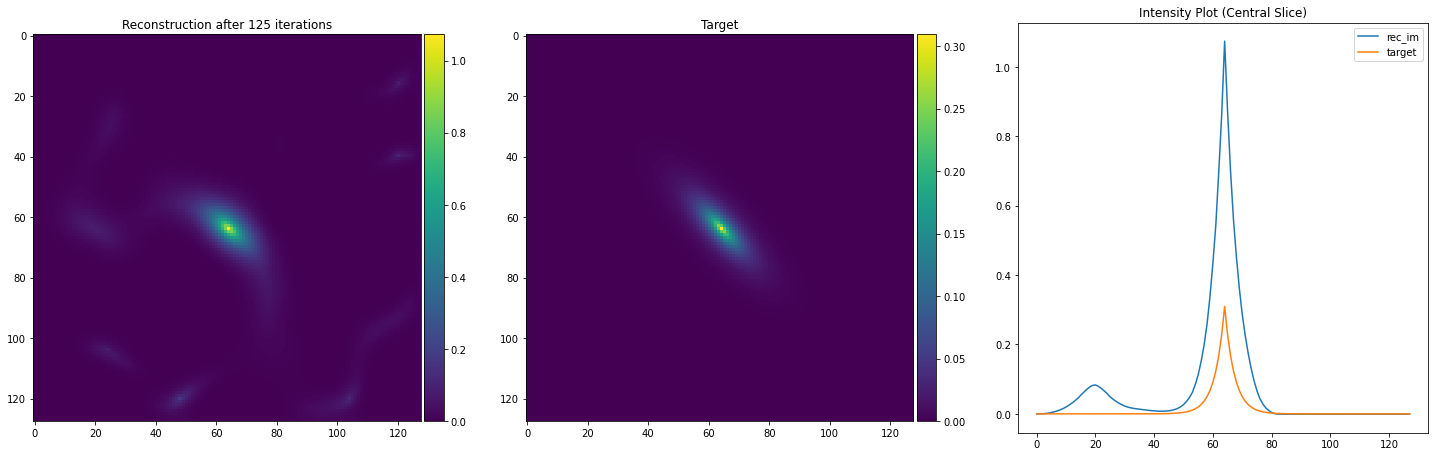

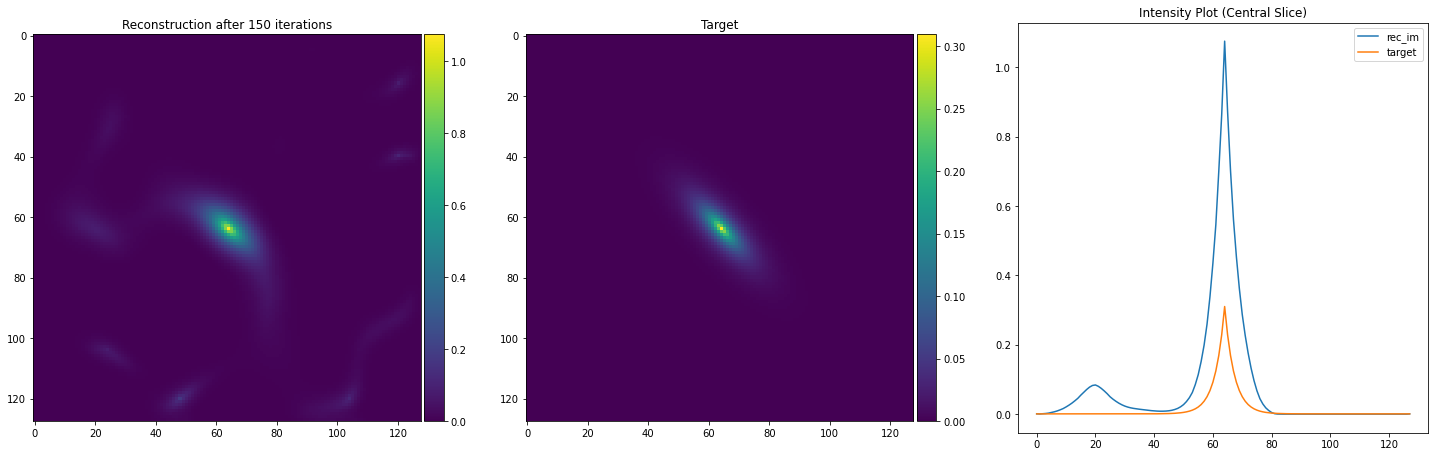

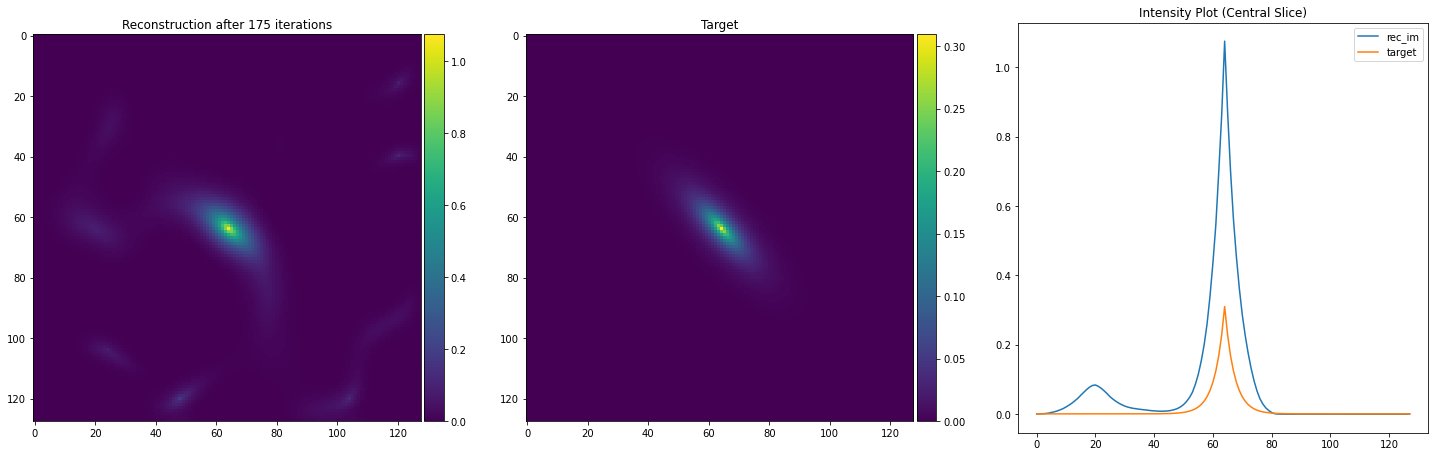

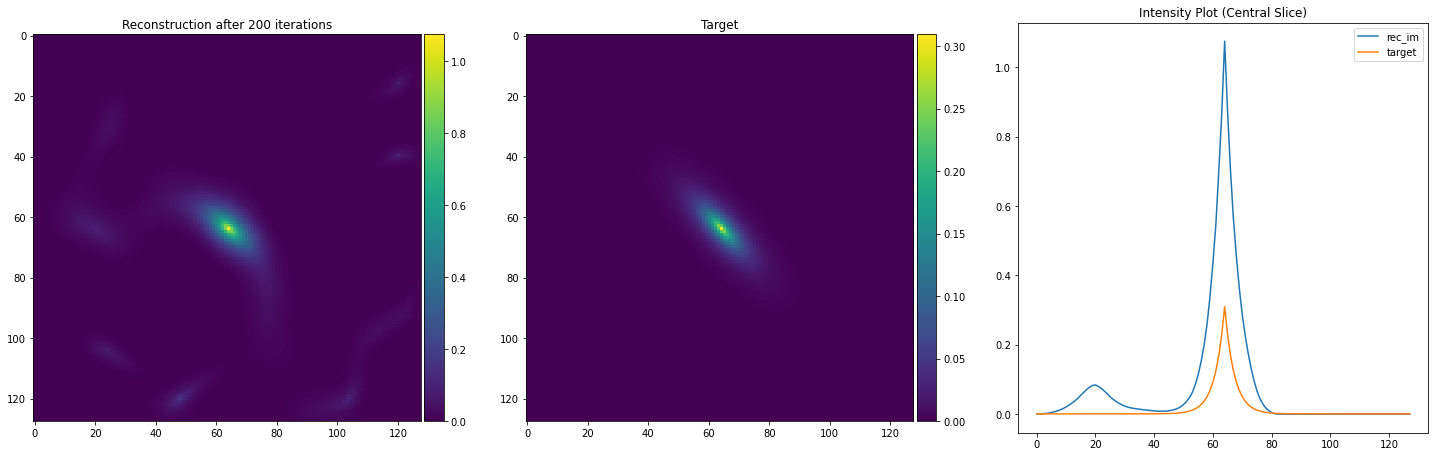

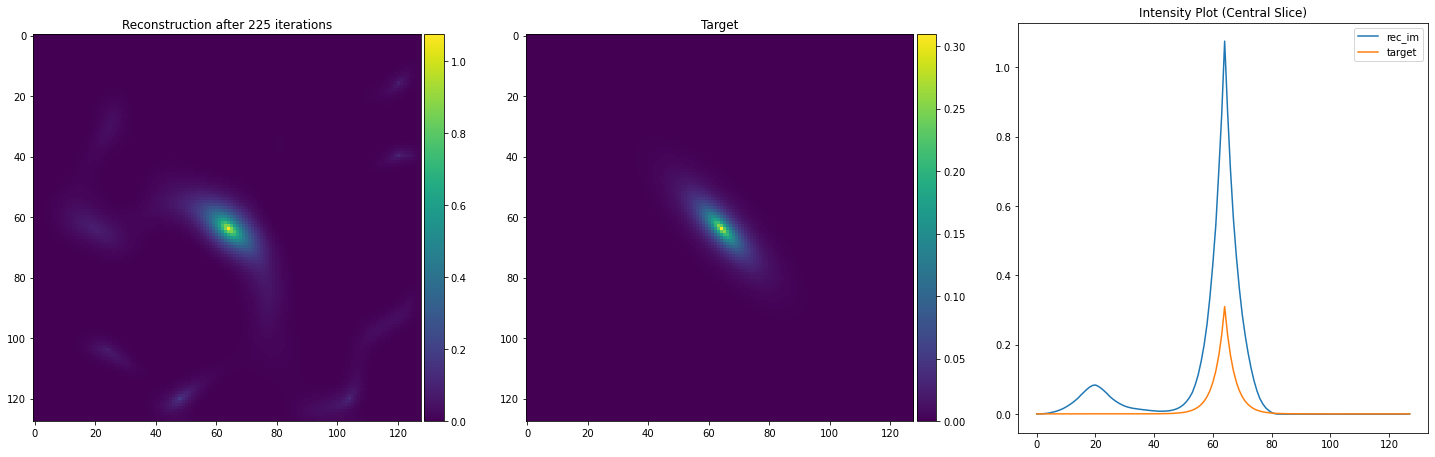

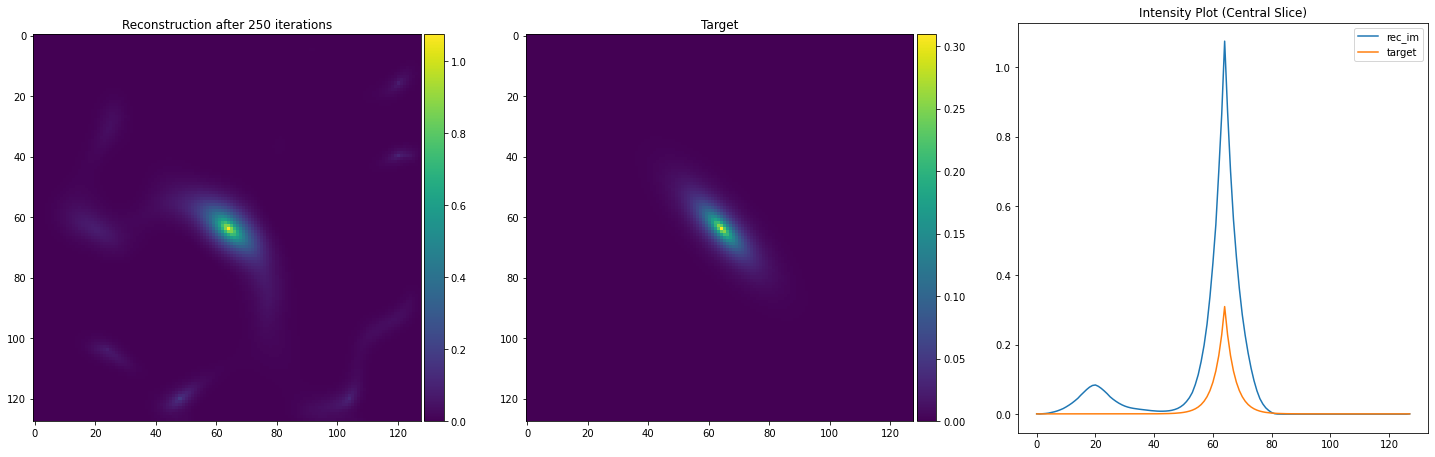

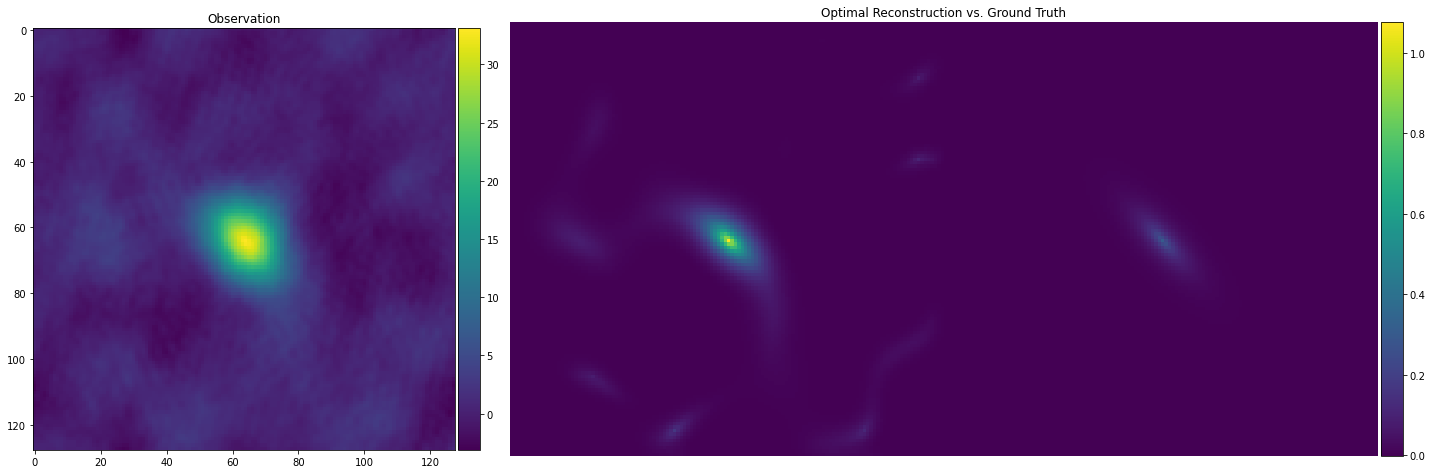

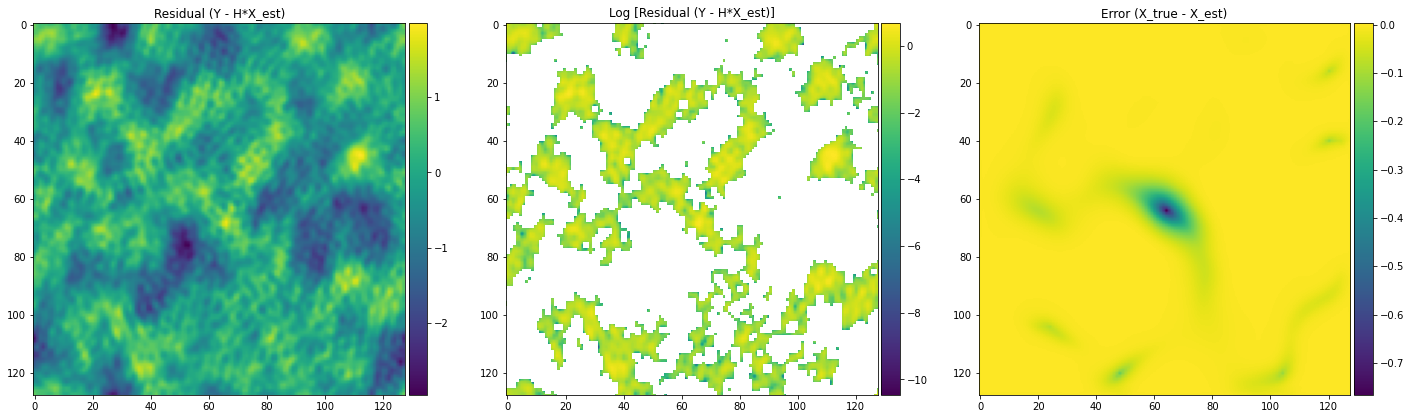

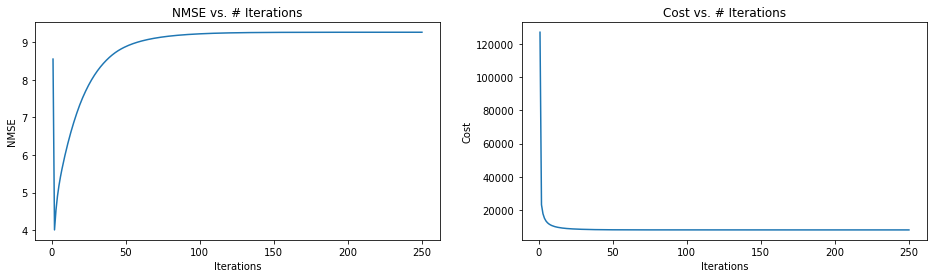


Minimum NMSE = 4.004142761230469 (at [2] iterations)
Minimum Cost = 7910.42822265625 (at [246 247 248 249 250] iterations)


 Gal_ind = 1600 | SNR_ind = 3




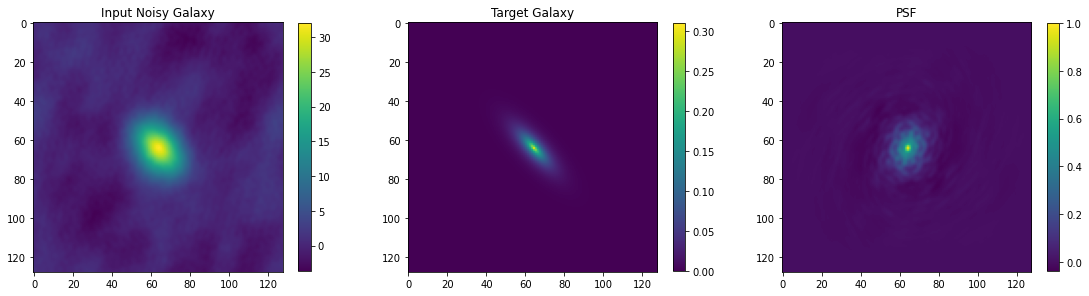

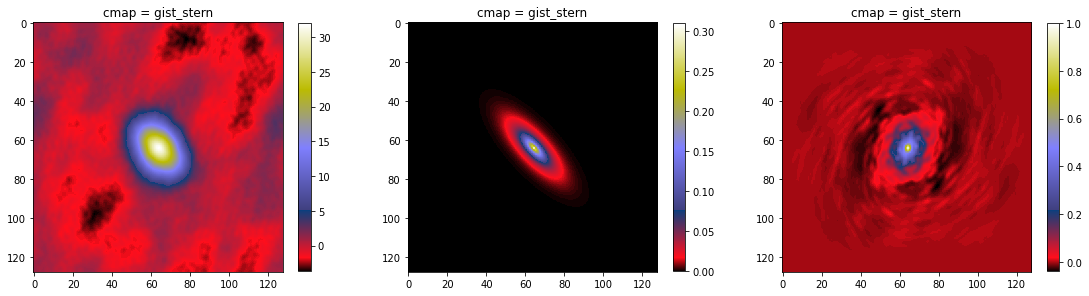

SNR (in Direct Space) = 54.96005
Noise Std (in Direct Space) = 0.5824841
PSF max. pixel value =  1.0


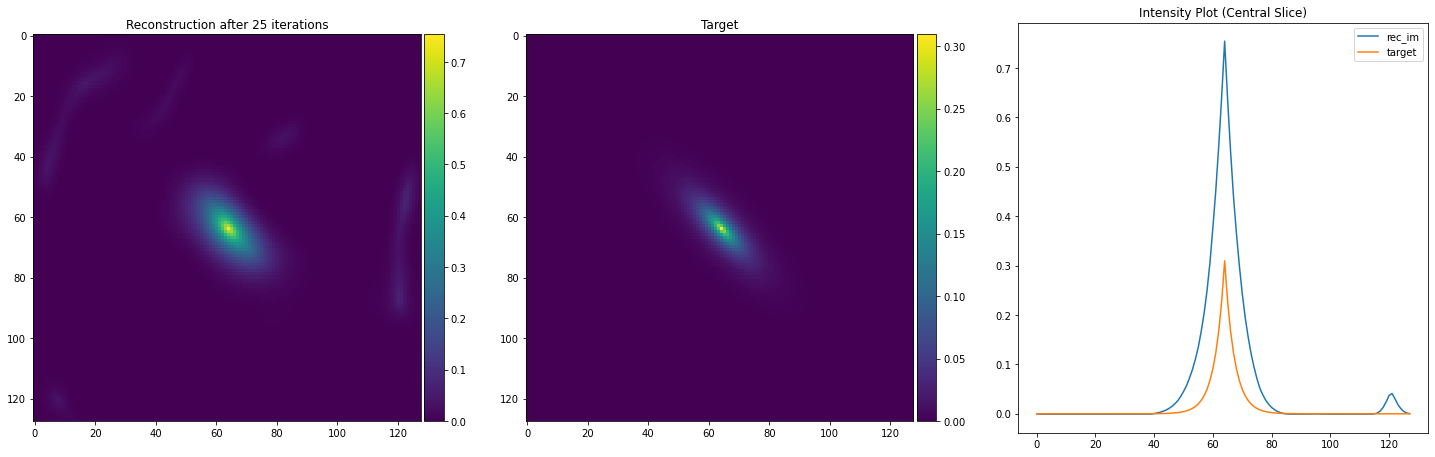

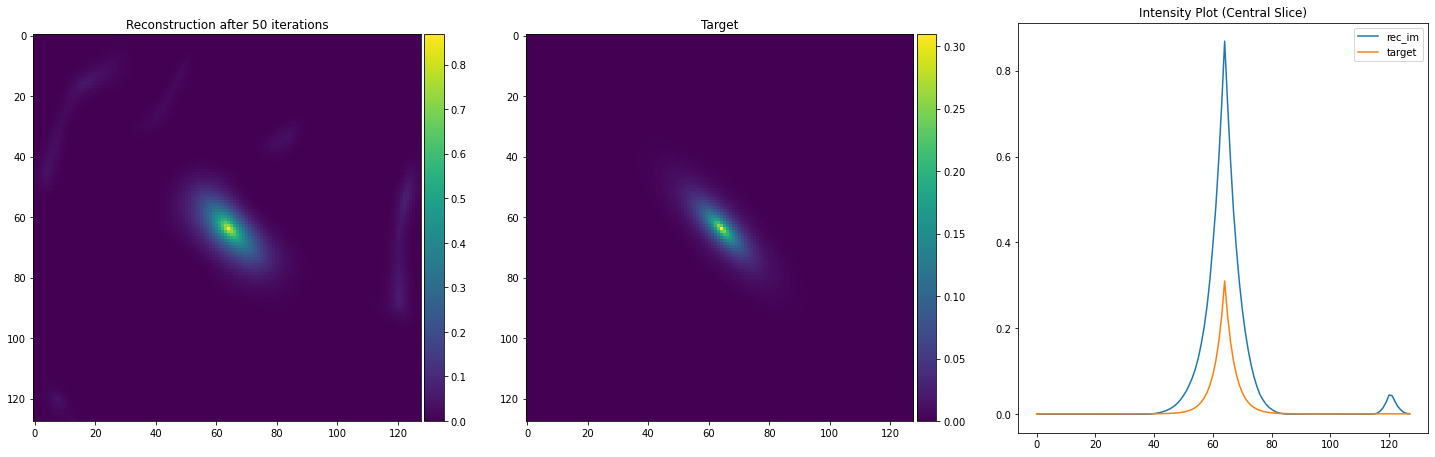

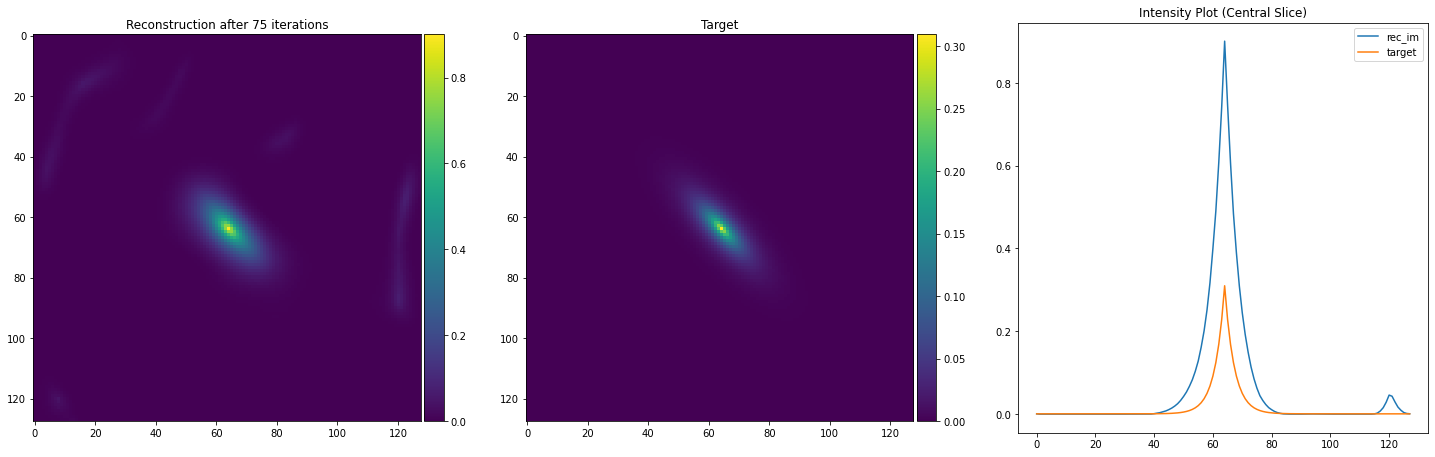

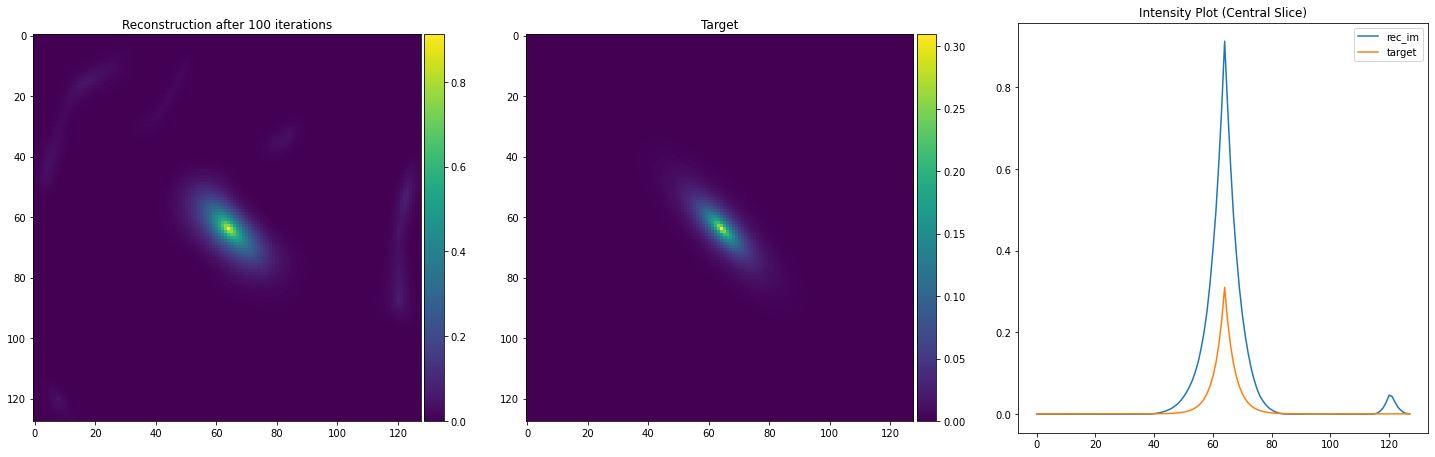

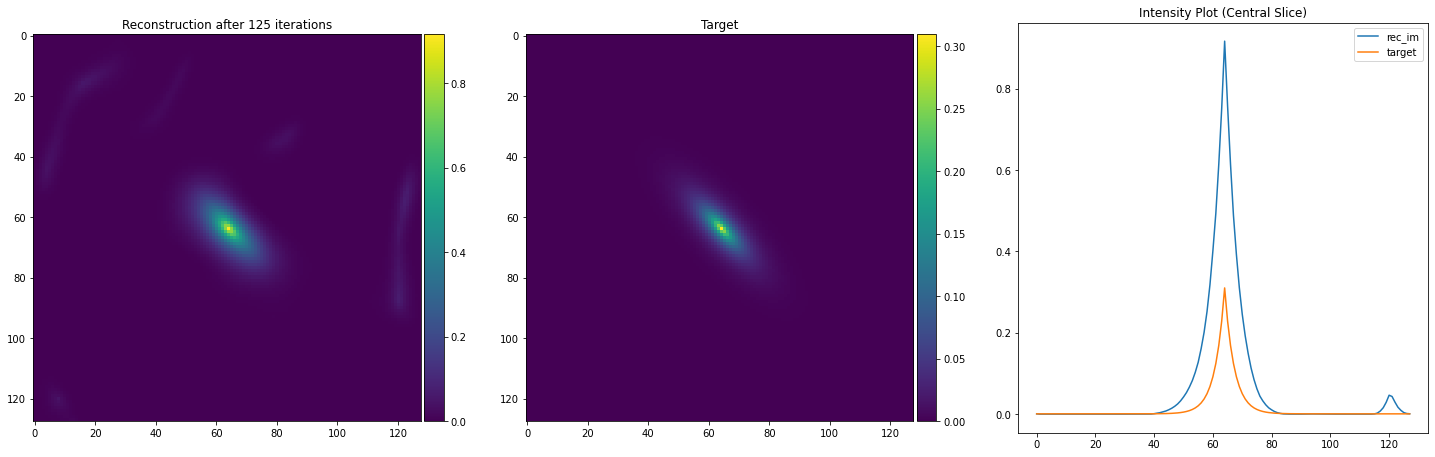

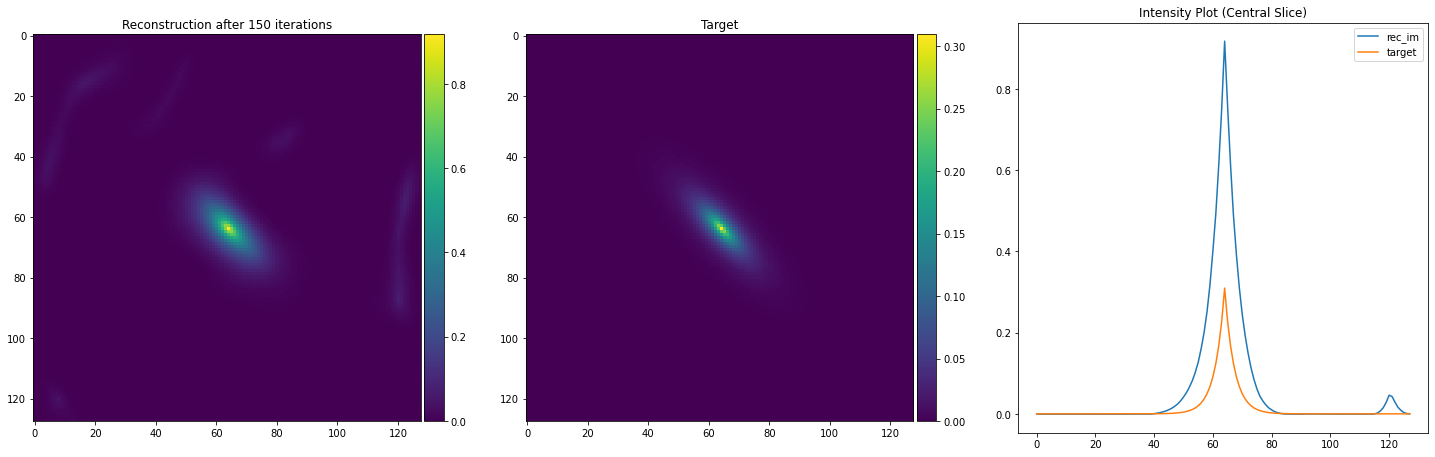

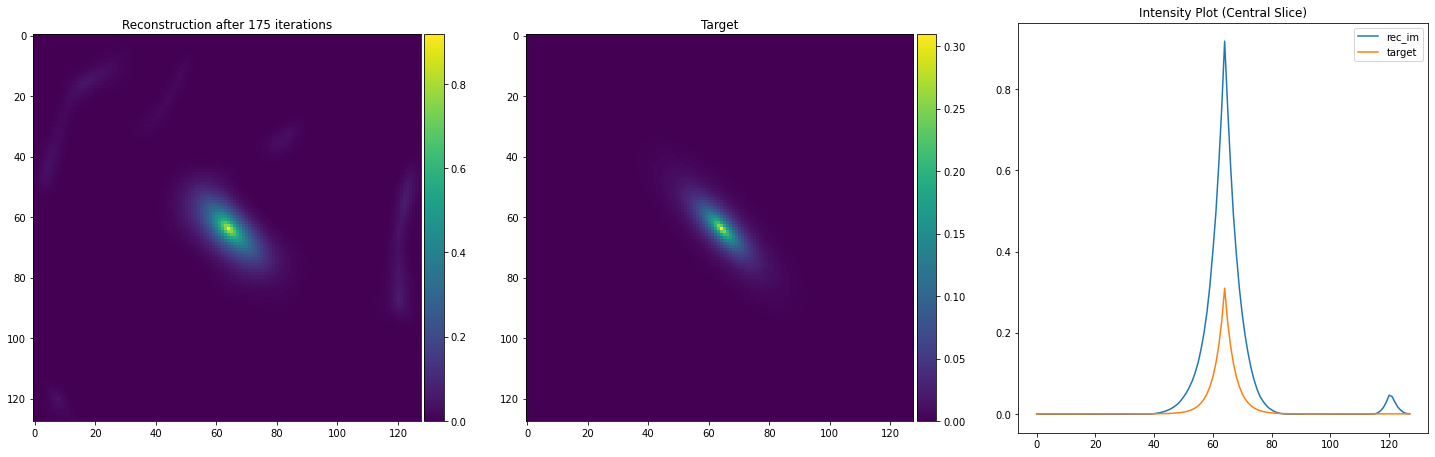

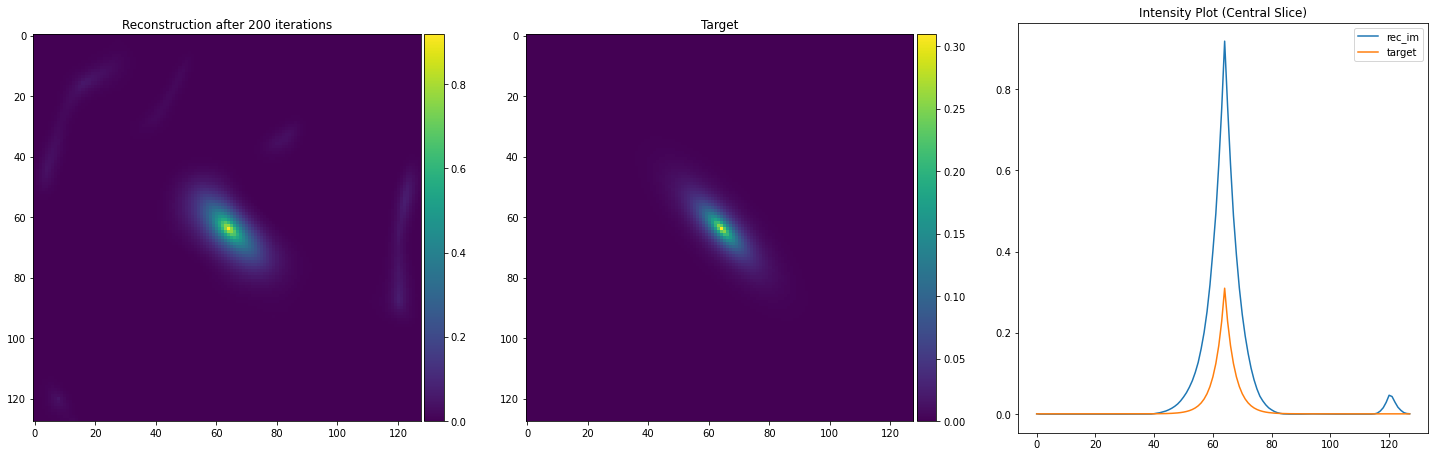

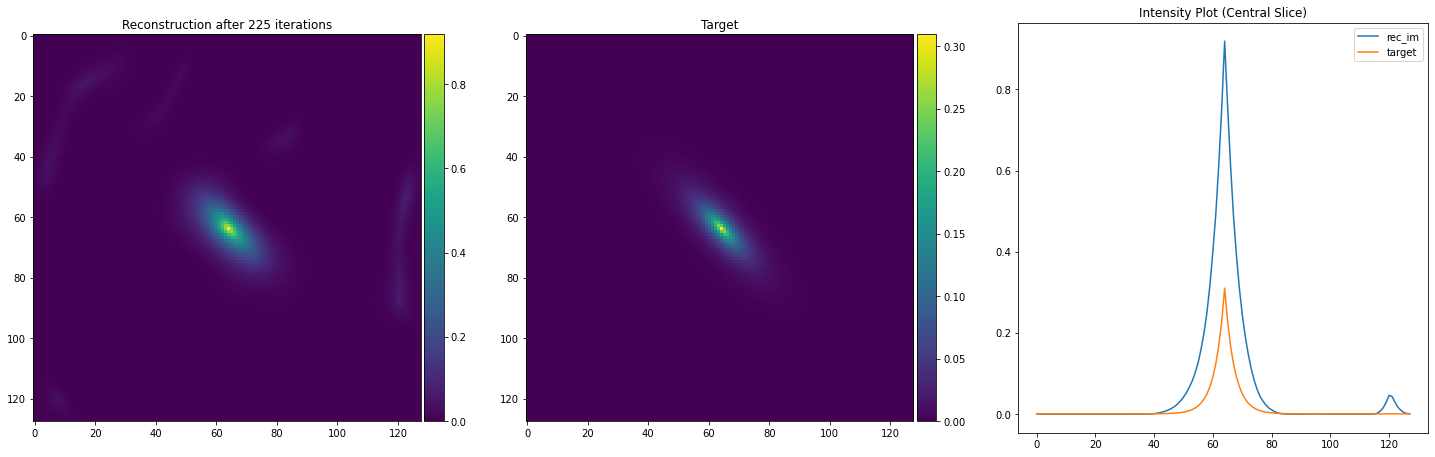

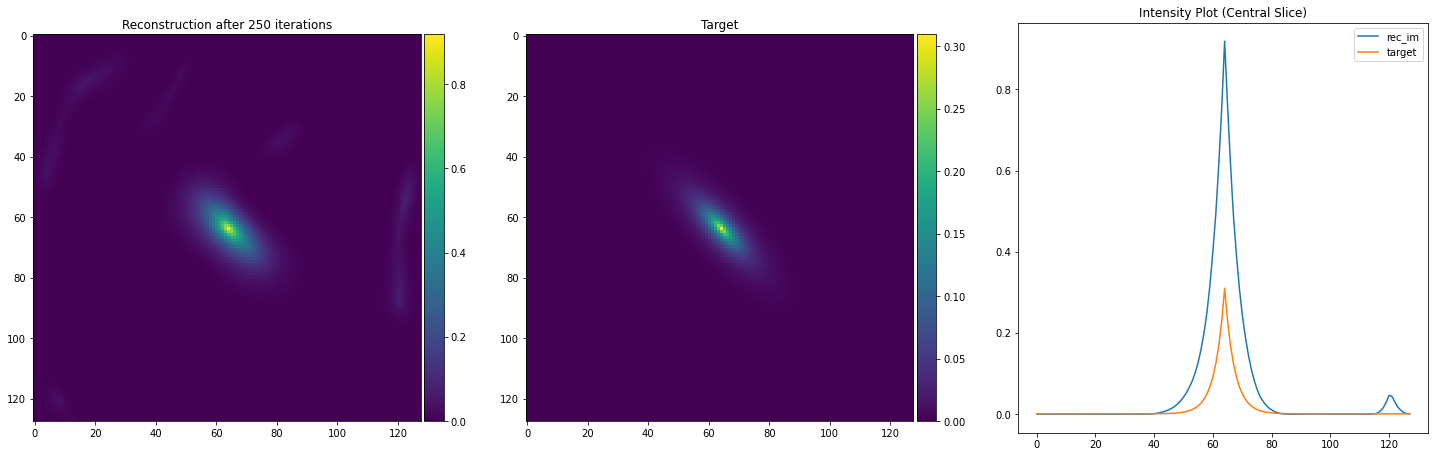

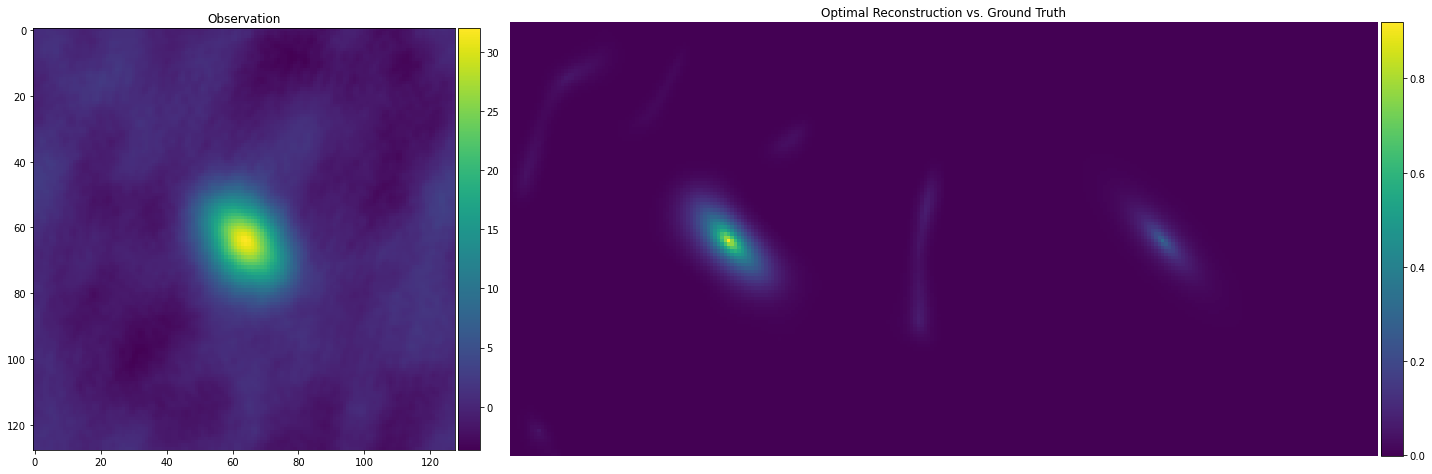

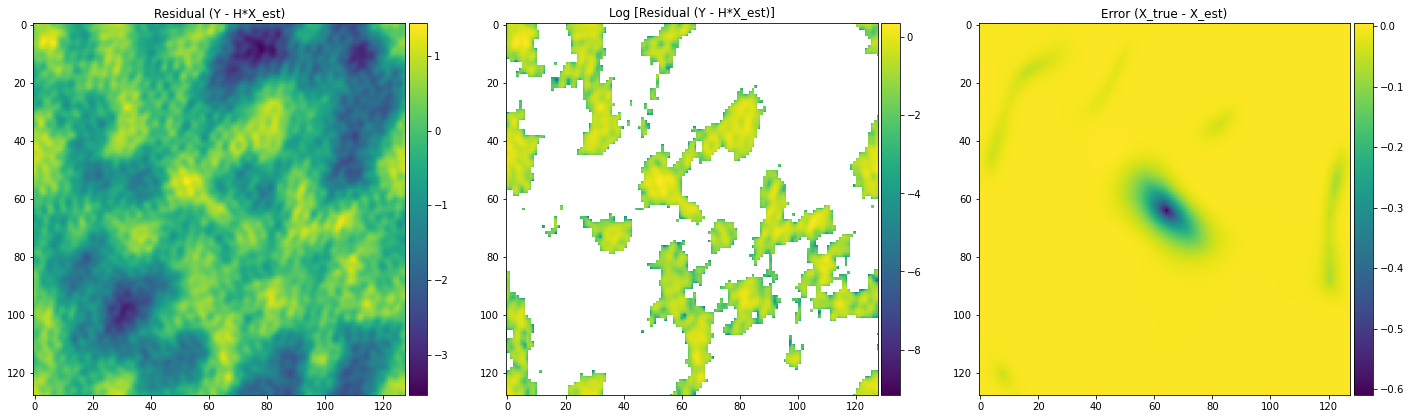

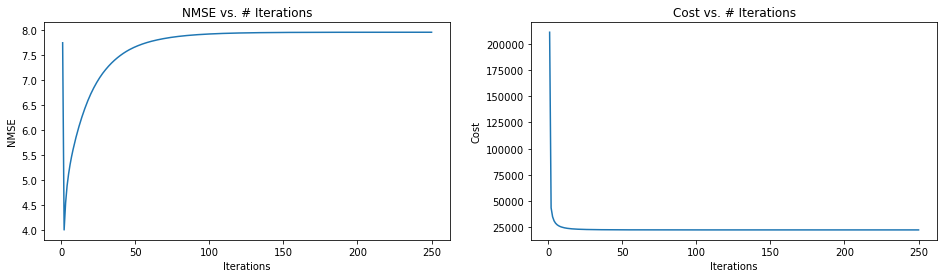


Minimum NMSE = 4.001734733581543 (at [2] iterations)
Minimum Cost = 22620.00390625 (at [245 246 247 248 249 250] iterations)


 Gal_ind = 1600 | SNR_ind = 4




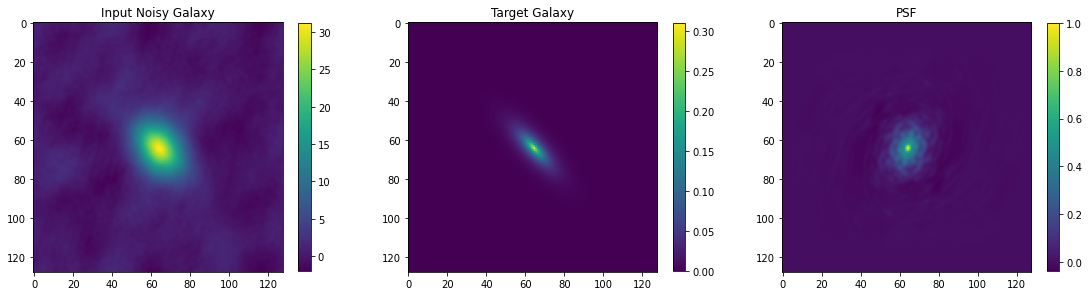

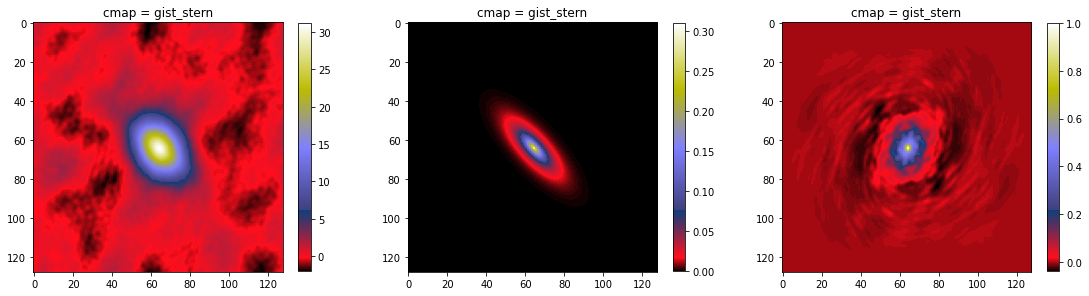

SNR (in Direct Space) = 57.113197
Noise Std (in Direct Space) = 0.5462124
PSF max. pixel value =  1.0


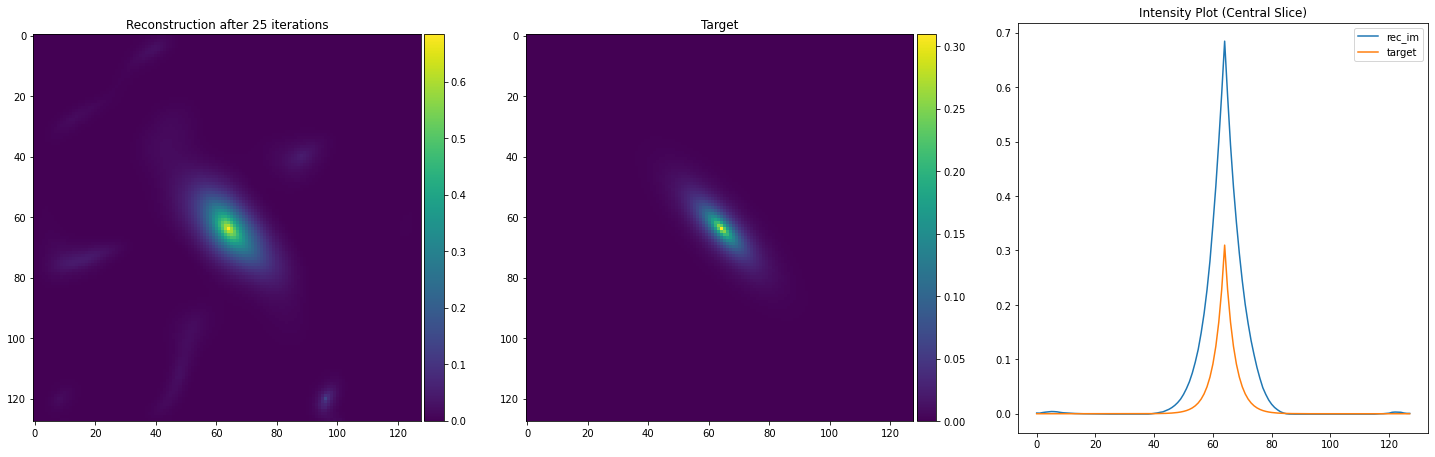

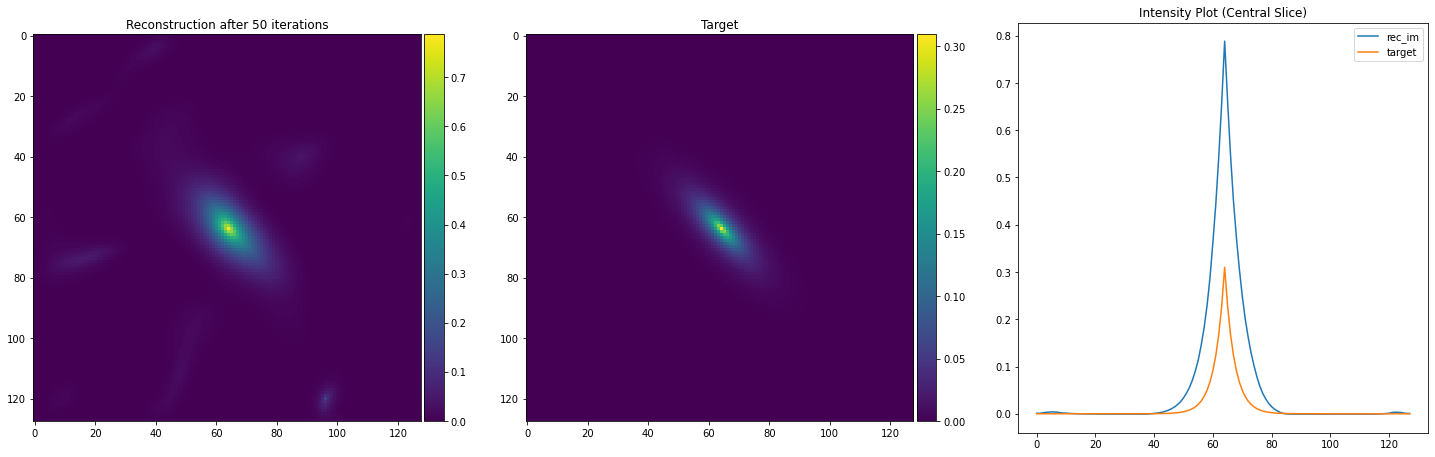

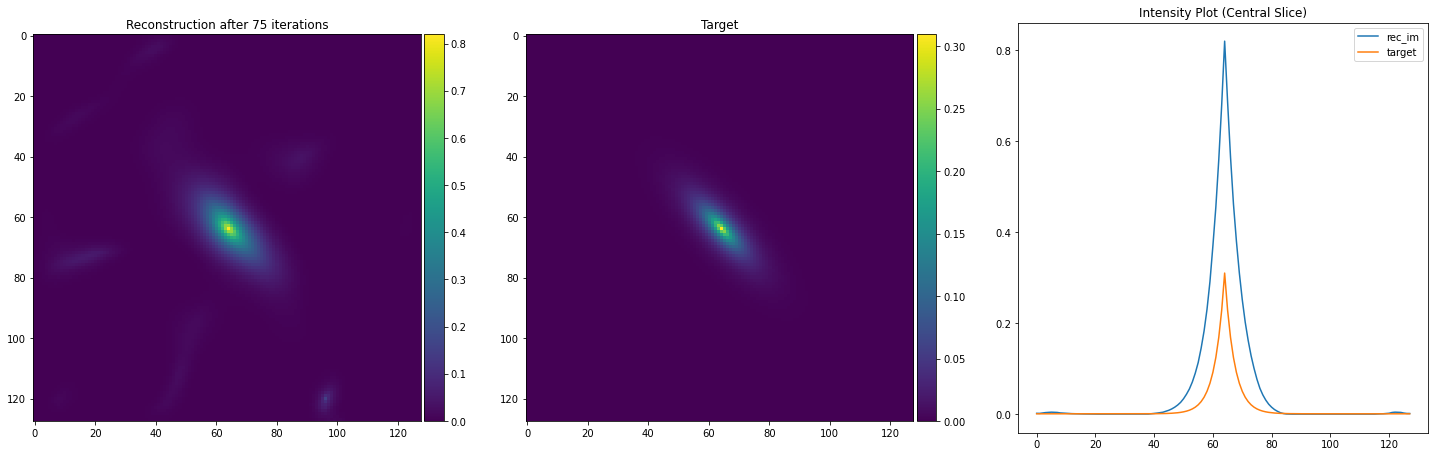

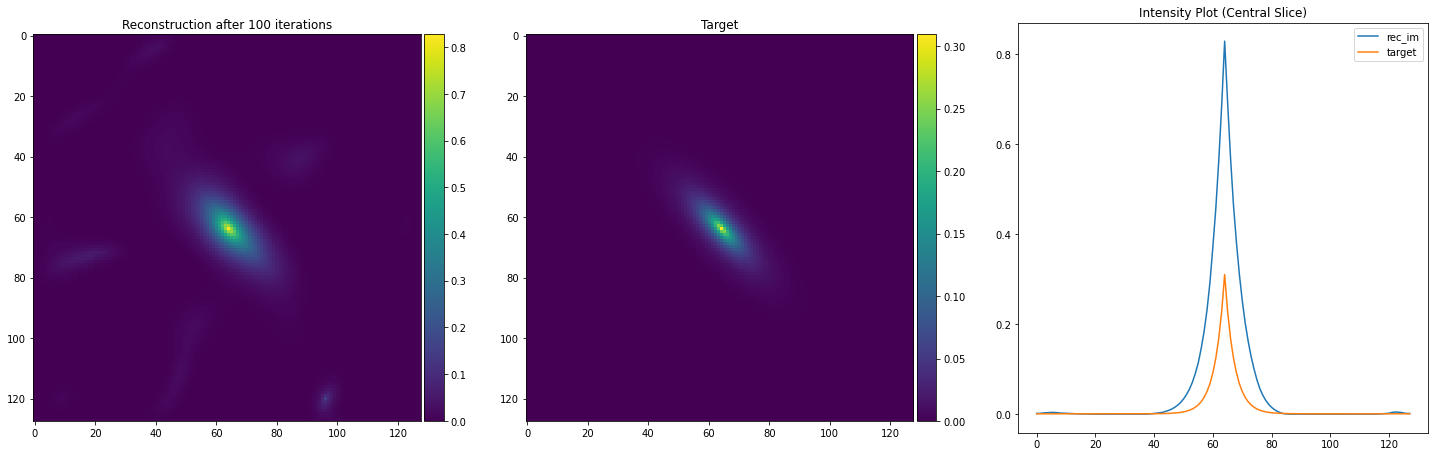

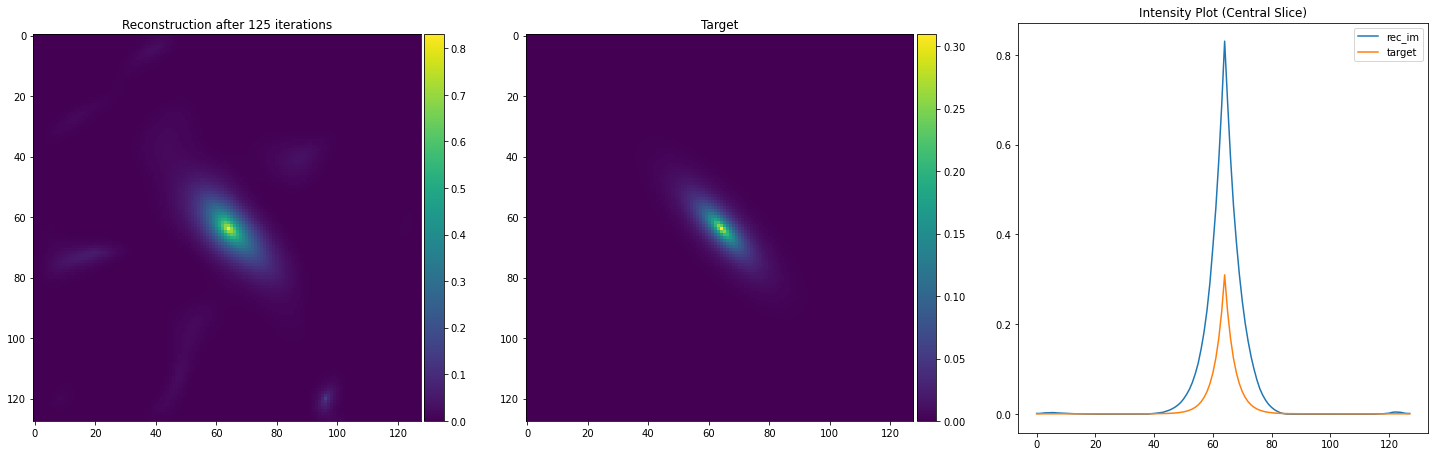

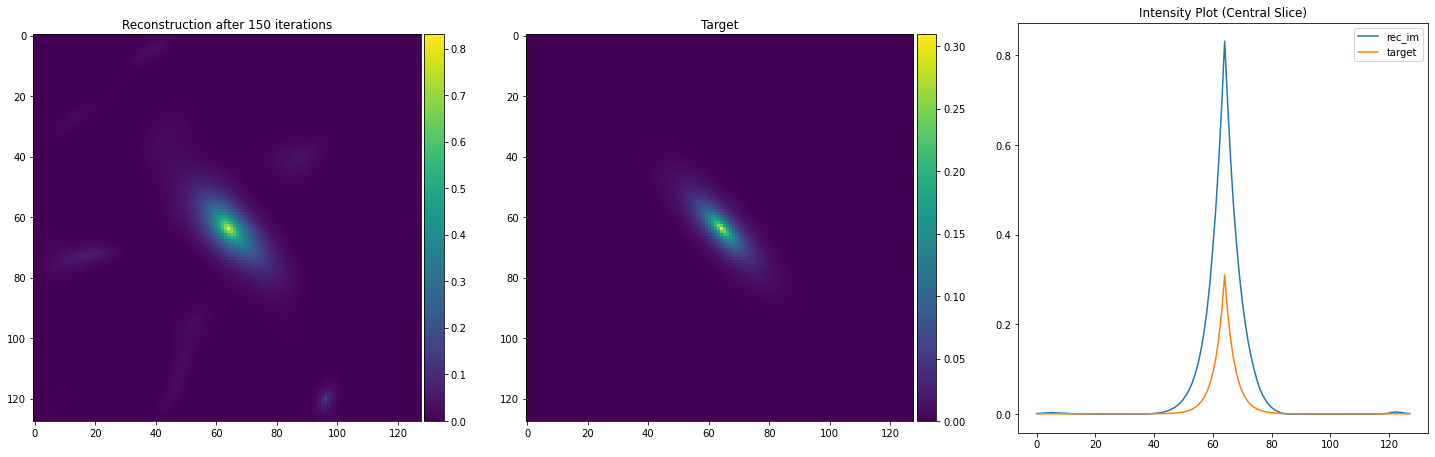

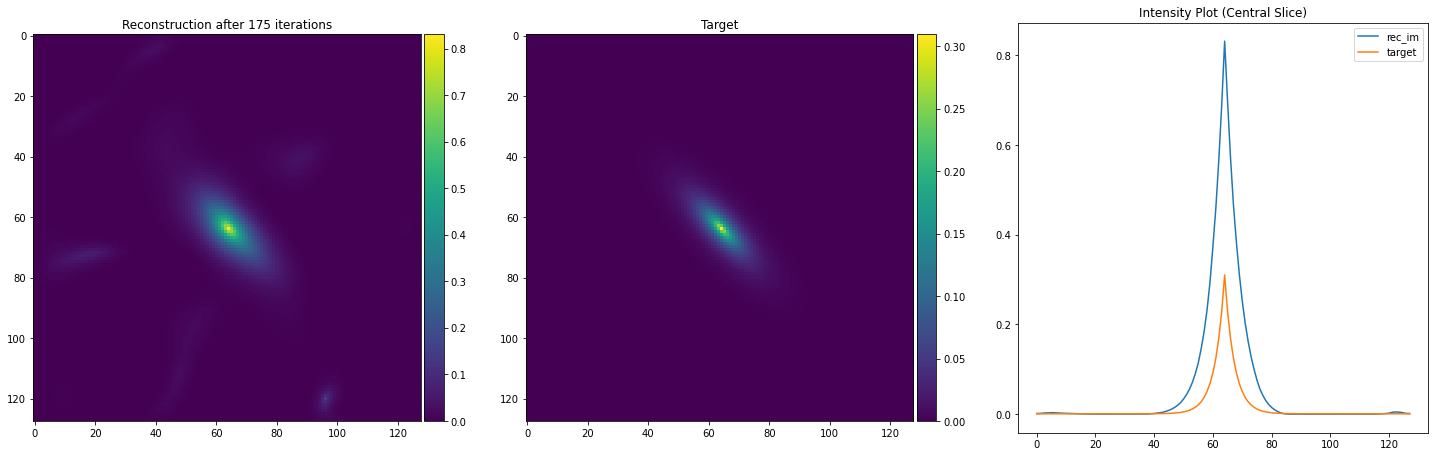

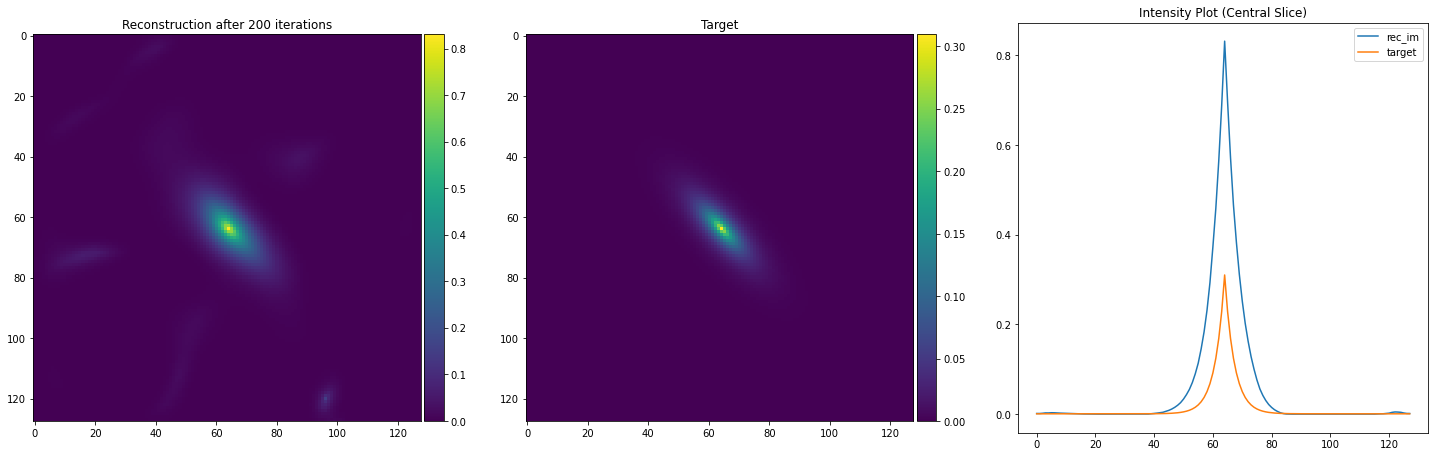

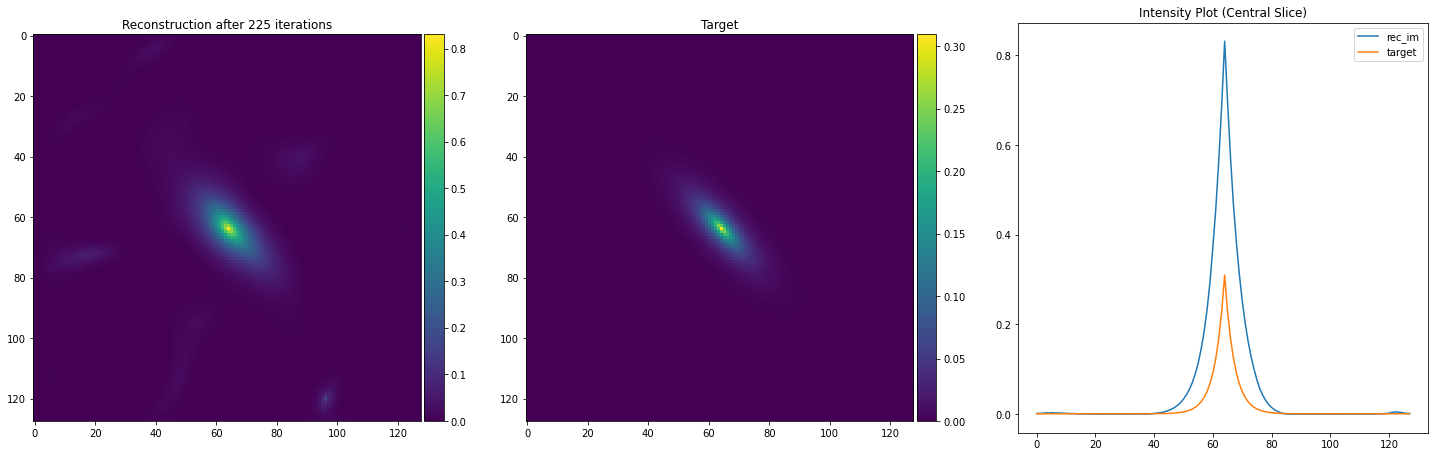

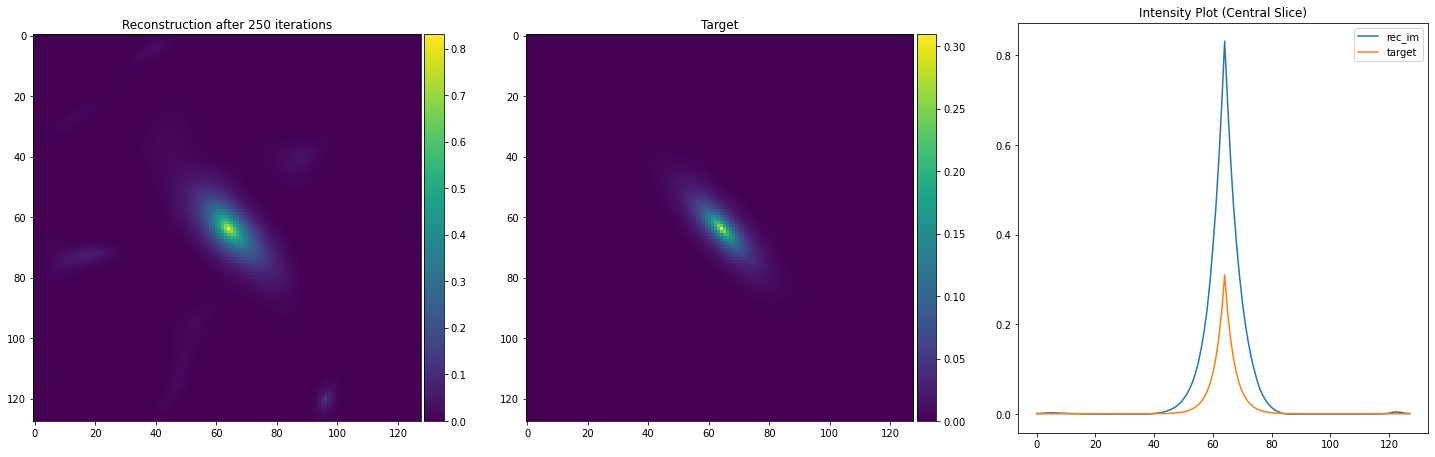

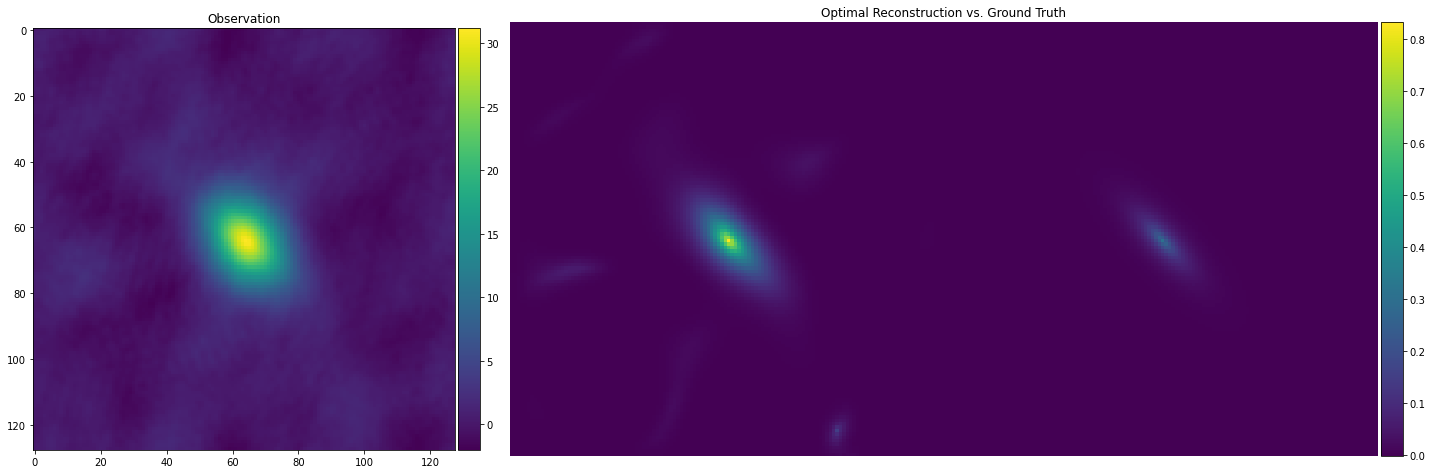

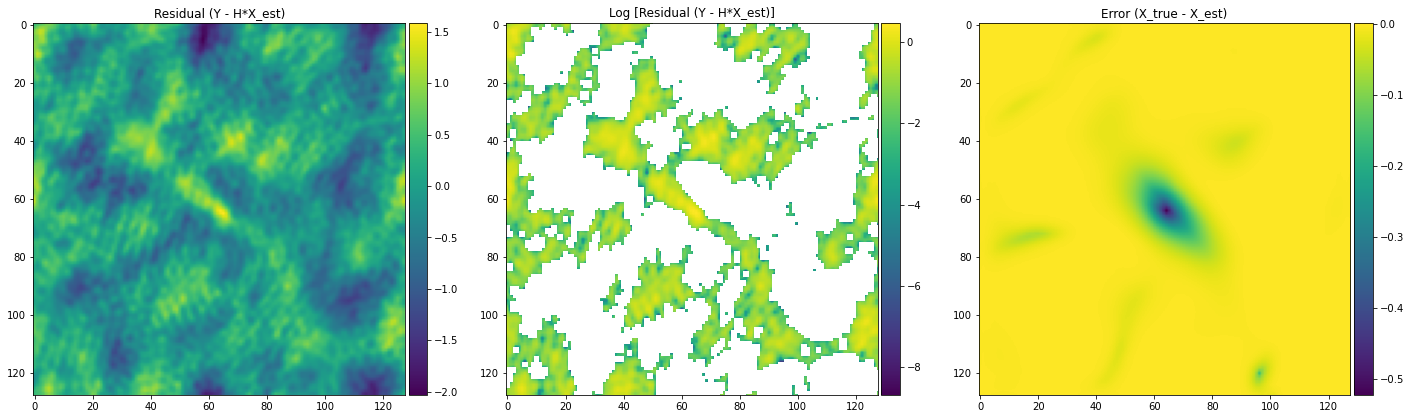

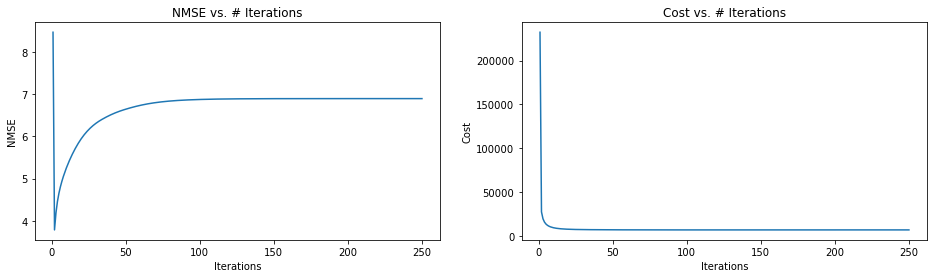


Minimum NMSE = 3.782756805419922 (at [2] iterations)
Minimum Cost = 6688.6103515625 (at [122] iterations)


In [12]:
n_iter = 250
disp_step = 25

x_0 = np.ones(batch[0][0][0].shape)

x_opt = {}                    # Dictionary storing optimal reconstruction
cost = {}                     # Dictionary storing cost function
nmse_arr = {}                 # Dictionary storing NMSE


# Deconvolve given images
for gal_ind in [1600]:              # Loop over galaxies
    for SNR_ind in range(batch[3].shape[1]):
    
        print('\n\n Gal_ind = {} | SNR_ind = {}'.format(gal_ind, SNR_ind))

        gal_input = np.squeeze(batch[0][gal_ind,SNR_ind,...])
        gal_target = np.squeeze(batch[1][gal_ind])
        psf = batch[2][gal_ind]
        sigma_noise = np.std(gal_input[0:20,0:20])      # compute noise std. ona a slice of image excluding central blob
        SNR_D = np.max(gal_input) / sigma_noise         # SNR in direct space

        # Plot input, target & psf 
        plot_utils.plot_gal_psf_radio(gal_input, gal_target, psf, sigma_noise, SNR_D)

        # Cast numpy arrays to tensors
        gal_input_tf = tf.cast(gal_input, tf.float32)
        psf_tf = tf.cast(psf, tf.float32) 
        gal_target_tf = tf.cast(gal_target, tf.float32)

        # Deconvolve the image
        x_opt["{}_{}".format(gal_ind,SNR_ind)], cost["{}_{}".format(gal_ind,SNR_ind)], nmse_arr["{}_{}".format(gal_ind,SNR_ind)] = runFBS(gal_input_tf, x_0, psf_tf, grad, sigma_noise, 
                                                                                                                                          disp_step, n_iter, model_1)
        # Visual Comparison
        plot_utils.comparison(x_opt["{}_{}".format(gal_ind,SNR_ind)], gal_target_tf, gal_input_tf, psf_tf, fftconvolve)

        # Plot NMSE & Cost
        plot_utils.nmse_cost(nmse_arr["{}_{}".format(gal_ind,SNR_ind)], cost["{}_{}".format(gal_ind,SNR_ind)], n_iter)